In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import functional as tf
import glob
from PIL import Image
import sys
import os
import time
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import random
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(88)

print(torch.__version__)
print(torch.cuda.is_available())
print('GPU name: ',torch.cuda.get_device_name(0))

1.12.0
True
GPU name:  NVIDIA GeForce RTX 3060 Ti


In [10]:
# load the other cohort's img and MRI
# right part for children
# MRI 
TD02_R = glob.glob('./data/png/*.png');
TD02_R = sorted(TD02_R);print('TD02_R: ',len(TD02_R))


# label 
TD02_R_anno = glob.glob('./data/label/*.png');
TD02_R_anno = sorted(TD02_R_anno);print('TD02_R_anno: ',len(TD02_R_anno))


TD02_R:  11
TD02_R_anno:  11


In [11]:
# model load
# load the trained wight

#——————————————————————————————————————————————————————————————————————
# Unet
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size = 2)
    
    def forward(self, x, is_pool=True):

        if is_pool: # 先看一下是否需要下采样pool层
            x = self.pool(x)

        x = self.conv_relu(x)

        return x

# 上采样模块
class Upsample(nn.Module):
    def __init__(self, channels):
        super(Upsample, self).__init__()
        self.conv_relu = nn.Sequential(nn.Conv2d(2*channels, channels, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(channels),
                                       nn.ReLU(inplace=True),
                                       
                                       nn.Conv2d(channels, channels, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(channels),
                                       nn.ReLU(inplace=True),
        )
        self.upconv = nn.Sequential(nn.ConvTranspose2d(channels, channels//2, kernel_size=3, stride=2,padding=1,output_padding=1)
        )
    
    def forward(self, x):
        x = self.conv_relu(x)
        x = self.upconv(x)
        return x

# 初始化模型
class Unet_model(nn.Module):
    def __init__(self):
        super(Unet_model, self).__init__()
        self.down1 = Downsample(1,64) # 输入图片是3通道的
        self.down2 = Downsample(64,128)
        self.down3 = Downsample(128,256)
        self.down4 = Downsample(256,512)
        self.down5 = Downsample(512,1024)

        self.up = nn.Sequential(nn.ConvTranspose2d(1024,512,kernel_size=3,stride=2,padding=1,output_padding=1),
                                #nn.Dropout(p=0.5),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True)
        )

        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)

        self.conv_2 = Downsample(128,64)

        self.last = nn.Sequential(nn.Conv2d(64,26,kernel_size=1),
                                  #nn.Dropout(p=0.5)
                                  ) # 因为是分25类，所以输出是26  25+1 
    
    def forward(self, input):
        x1 = self.down1(input, is_pool=False)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)

        x5 = self.up(x5)

        x5 = torch.cat([x4,x5], dim=1) #沿着channel维度进行合并
        x5 = self.up1(x5) 

        x5 = torch.cat([x3,x5], dim=1)
        x5 = self.up2(x5) 

        x5 = torch.cat([x2,x5], dim=1)
        x5 = self.up3(x5) 

        x5 = torch.cat([x1,x5], dim=1)

        x5 = self.conv_2(x5, is_pool=False)

        x5 = self.last(x5)

        return x5





In [12]:
# combine the dataset
# train dataset

train_images = ( TD02_R
             
                
               )
train_images = sorted(train_images)
                      
train_images = train_images[0:len(train_images):2]


# train_ground
train_annos = (  TD02_R_anno
          
               )
      
train_annos = sorted(train_annos) 

train_annos = train_annos[0:len(train_annos):2]
#

test_images = TD02_R
test_images = sorted(test_images) 
test_images = test_images[0:len(test_images):1]

test_annos = TD02_R_anno
test_annos = sorted(test_annos) 
test_annos = test_annos[0:len(test_annos):1]

In [13]:
# shuffle
np.random.seed(188)
index = np.random.permutation(len(train_images))
print('all number:',index)

train_images=np.array(train_images)[index]
train_annos=np.array(train_annos)[index]



# 分trian集和vali集
vali_images=train_images
vali_annos=train_annos

train_images = train_images[0:int(0.9*len(index))]
train_annos = train_annos[0:int(0.9*len(index))]

vali_images = vali_images[int(0.9*len(index)):]
vali_annos = vali_annos[int(0.9*len(index)):]

all number: [3 0 4 1 5 2]


In [14]:
#————————————————————————————————————————————————————————————————————————————————————————
# define transform
# randomly crop the image size to 128*128 to save the cost
transform = transforms.Compose([
                                
                                transforms.ToTensor(), 
])

class Dataset(data.Dataset):
    def __init__(self, imgs_path, annos_path,cropp=False):
        self.imgs_path = imgs_path
        self.annos_path = annos_path
        self.cropp = cropp
    def crop(self,img,label,size):
        t = transforms.RandomCrop.get_params(img=img,output_size=(size,size))
        img = tf.crop(img, *t)
        label = tf.crop(label, *t)
        return img,label
    
    def __getitem__(self, index):
        img = self.imgs_path[index]
        anno = self.annos_path[index]

        pil_img = Image.open(img)#.convert('RGB')
        anno_img = Image.open(anno).convert('L')
        
        if self.cropp:
            pil_img,anno_img = self.crop(pil_img,anno_img,128)
        
        img_tensor = transform(pil_img)
        img_tensor = img_tensor.to(torch.float)
        anno_tensor = transform(anno_img)
        anno_tensor = anno_tensor*255. 
        anno_tensor = torch.squeeze(anno_tensor).type(torch.long) 

        return img_tensor, anno_tensor
    
    def __len__(self):
        return len(self.imgs_path)

In [15]:
# 合成数据
train_dataset = Dataset(train_images,train_annos,cropp=True)

vali_dataset = Dataset(vali_images,vali_annos,cropp=True)

test_dataset = Dataset(test_images,test_annos)

ok
the shape of img: torch.Size([2, 1, 128, 128])
the shape of anno: torch.Size([2, 128, 128])
(128, 128)


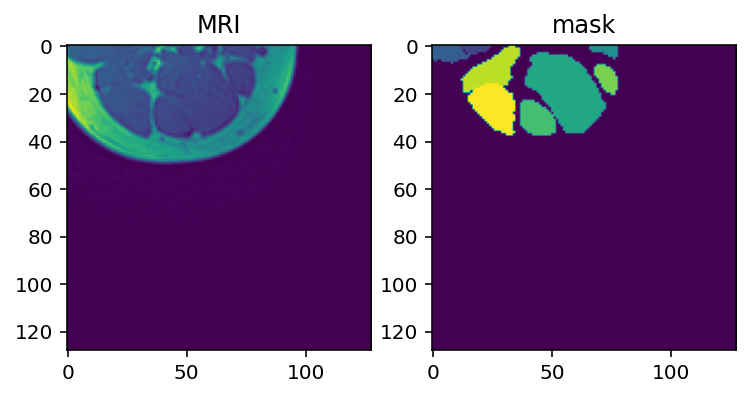

In [16]:


print('ok')

batchsize = 2
# test1 is test data
test_dataloader = data.DataLoader(test_dataset,
                                   batch_size = 1,
                                   shuffle=True,
                                  num_workers=0) # 因为是预测，所以测试集的batchsize就设置成1

train_dataloader = data.DataLoader(train_dataset,
                                   batch_size = batchsize,
                                   shuffle=True,
                                   num_workers=0)

#validation data
vali_dataloader = data.DataLoader(vali_dataset,
                                   batch_size = batchsize,
                                  shuffle=True,
                                  num_workers=0)

#————————————————————————————————————————————————————————————————————————————————————————
img_batch, anno_batch = next(iter(train_dataloader))
print('the shape of img:',img_batch.shape) # [b,3,256,256]
print('the shape of anno:',anno_batch.shape) # [b,256,256]

#————————————————————————————————————————————————————————————————————————————————————————


# img = img_batch[0].permute(1,2,0).numpy() 
img = torch.squeeze(img_batch[0].permute(1,2,0))
img = img.numpy()
anno = anno_batch[0].numpy()
print(img.shape)

plt.subplot(1,2,1)
plt.title('MRI')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('mask')
plt.imshow(anno)

In [17]:

###
#    Unet
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size = 2)
    
    def forward(self, x, is_pool=True):

        if is_pool: 
            x = self.pool(x)

        x = self.conv_relu(x)

        return x


class Upsample(nn.Module):
    def __init__(self, channels):
        super(Upsample, self).__init__()
        self.conv_relu = nn.Sequential(nn.Conv2d(2*channels, channels, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(channels),
                                       nn.ReLU(inplace=True),
                                       
                                       nn.Conv2d(channels, channels, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(channels),
                                       nn.ReLU(inplace=True),
        )
        self.upconv = nn.Sequential(nn.ConvTranspose2d(channels, channels//2, kernel_size=3, stride=2,padding=1,output_padding=1)
        )
    
    def forward(self, x):
        x = self.conv_relu(x)
        x = self.upconv(x)
        return x


class Unet_model(nn.Module):
    def __init__(self):
        super(Unet_model, self).__init__()
        self.down1 = Downsample(1,64) # 
        self.down2 = Downsample(64,128)
        self.down3 = Downsample(128,256)
        self.down4 = Downsample(256,512)
        self.down5 = Downsample(512,1024)

        self.up = nn.Sequential(nn.ConvTranspose2d(1024,512,kernel_size=3,stride=2,padding=1,output_padding=1),
                                #nn.Dropout(p=0.5),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True)
        )

        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)

        self.conv_2 = Downsample(128,64)

        self.last = nn.Sequential(nn.Conv2d(64,26,kernel_size=1),
                                  #nn.Dropout(p=0.5)
                                  ) # 
    
    def forward(self, input):
        x1 = self.down1(input, is_pool=False)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)

        x5 = self.up(x5)

        x5 = torch.cat([x4,x5], dim=1) 
        x5 = self.up1(x5) 

        x5 = torch.cat([x3,x5], dim=1)
        x5 = self.up2(x5) 

        x5 = torch.cat([x2,x5], dim=1)
        x5 = self.up3(x5) 

        x5 = torch.cat([x1,x5], dim=1)

        x5 = self.conv_2(x5, is_pool=False)

        x5 = self.last(x5)

        return x5

In [155]:
# when epoch = 1, run this code to set up a new file to record loss in each step
# if epoch !=1, don't run this code

train_loss_each_step = []
np.save('train_loss_each_step.npy',train_loss_each_step)
train_acc_each_step = []
np.save('train_acc_each_step.npy',train_acc_each_step)
vali_dice_each_epoch = []
np.save('vali_dice_each_epoch.npy',vali_dice_each_epoch)

vali_loss_each_epoch = []
np.save('vali_loss_each_epoch.npy',vali_loss_each_epoch)
vali_acc_each_epoch = []
np.save('vali_acc_each_epoch.npy',vali_acc_each_epoch)

test_dice_each_epoch = []
np.save('test_dice_each_epoch.npy',test_dice_each_epoch)


os.makedirs('./Save_weights')

In [157]:
model =  Unet_model()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

loss_fn = nn.CrossEntropyLoss(weight = torch.from_numpy(np.array([0.1, 1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0 ])).float()).to(device)
# crossentropy is used for multi segmentaion task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001*(0.9**0),weight_decay=0.001)
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) # 学习速率进行衰减

def fit(epoch,model,trian_dataloader,test_dataloder,train_loss_each_step,train_acc_each_step,vali_dice_each_epoch,vali_loss_each_epoch,vali_acc_each_epoch,test_dice_each_epoch):
    
    #——————————————————————————————————————————————————————————————————————
    #————————————————train—————————————————————————————————————————————————
    model.train()
    step = 0; #define the step in each epoch
    for x, y in train_dataloader:
        
        x = x.to(device)
        y = y.to(device)


        step = step+1
        
        y_pred = model(x)
        loss = loss_fn(y_pred, y) 
        # y_pred [batch,class_num,depth,height,width]
        # y      [batch,depth,height,width]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # acc caculate
        y_pred = torch.argmax(y_pred,dim=1)
        correct = 0
        correct += (y == y_pred).sum().item()
        N = y.size(0)
        acc = correct/(N*128*128)

        
        #print for every step
        print('epoch:',epoch,'step:',step,'loss:',loss.detach().cpu().numpy(),'acc:',acc)
        train_loss_each_step = np.append(train_loss_each_step, loss.detach().cpu().numpy())
        train_acc_each_step = np.append(train_acc_each_step, acc) 


        ##################################################
       # wandb.log({"train_acc_each_step": acc})
       # wandb.log({"train_loss_each_step": loss.detach().cpu().numpy()})

    exp_lr_scheduler.step()
    
    
    #——————————————————————————————————————————————————————————————————————
    #————————————————vali——————————————————————————————————————————————————
    model.eval()
    vali_running_loss = 0 #record the sum of loss
    dice_total = 0
    acc_vali_total = 0
    acc_num = 0

    with torch.no_grad():
        dice_1 = [] # 
        dice_2 = [] # 
        dice_3 = [] # 
        dice_4 = [] # 
        dice_5 = [] # 
        dice_6 = [] # 
        dice_7 = [] # 
        dice_8 = [] # 
        dice_9 = []
        dice_10 = []
        dice_11 = []
        dice_12 = [] # 
        dice_13 = [] # 
        dice_14 = [] # 
        dice_15 = [] # 
        dice_16 = [] # 
        dice_17 = [] # 
        dice_18 = [] # 
        dice_19 = []
        dice_20 = []
        dice_21 = []
        dice_22 = []
        dice_23 = []
        dice_24 = []
        dice_25 = []
        for x, y in vali_dataloader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)

            # acc caculate
            y_pred_here = y_pred
            y_pred_here = torch.argmax(y_pred_here,dim=1)
            correct = 0
            correct += (y ==y_pred_here).sum().item()
            N = y.size(0)
            acc = correct/(N*128*128)
            acc_vali_total = acc_vali_total + acc
            acc_num = acc_num + 1



            # loss ca
            loss = loss_fn(y_pred, y)
            vali_running_loss += loss.item()



            y_pred = torch.argmax(y_pred, dim=1)
            y_pred = y_pred.cpu().detach().numpy()
            smooth = 1e-5
            y = y.cpu().detach().numpy()

            aa = 0.
            lossFdice = 0.


            # calculate each class's dice
            # total 25 classes
            if 1 in y:
              intersection_1 = np.sum((y == 1) & (y_pred == 1))
              union_set_1 = np.sum(y == 1) + np.sum(y_pred == 1)
              lossFdice_1 = 2*(intersection_1 + smooth)/(union_set_1 + smooth)
              dice_1.append(lossFdice_1)
            if 2 in y:
              intersection_2 = np.sum((y == 2) & (y_pred == 2))
              union_set_2 = np.sum(y == 2) + np.sum(y_pred == 2)
              lossFdice_2 = 2*(intersection_2 + smooth)/(union_set_2 + smooth)
              dice_2.append(lossFdice_2)
            if 3 in y:
              intersection_3 = np.sum((y == 3) & (y_pred == 3))
              union_set_3 = np.sum(y == 3) + np.sum(y_pred == 3)
              lossFdice_3 = 2*(intersection_3 + smooth)/(union_set_3 + smooth)
              dice_3.append(lossFdice_3)
            if 4 in y:
              intersection_4 = np.sum((y == 4) & (y_pred == 4))
              union_set_4 = np.sum(y == 4) + np.sum(y_pred == 4)
              lossFdice_4 = 2*(intersection_4 + smooth)/(union_set_4 + smooth)
              dice_4.append(lossFdice_4)
            if 5 in y:
              intersection_5 = np.sum((y == 5) & (y_pred == 5))
              union_set_5 = np.sum(y == 5) + np.sum(y_pred == 5)
              lossFdice_5 = 2*(intersection_5 + smooth)/(union_set_5 + smooth)
              dice_5.append(lossFdice_5)
            if 6 in y: 
              intersection_6 = np.sum((y == 6) & (y_pred == 6))
              union_set_6 = np.sum(y == 6) + np.sum(y_pred == 6)
              lossFdice_6 = 2*(intersection_6 + smooth)/(union_set_6 + smooth)
              dice_6.append(lossFdice_6)
            if 7 in y:
              intersection_7 = np.sum((y == 7) & (y_pred == 7))
              union_set_7 = np.sum(y == 7) + np.sum(y_pred == 7)
              lossFdice_7 = 2*(intersection_7 + smooth)/(union_set_7 + smooth)
              dice_7.append(lossFdice_7)
            if 8 in y:
              intersection_8 = np.sum((y == 8) & (y_pred == 8))
              union_set_8 = np.sum(y == 8) + np.sum(y_pred == 8)
              lossFdice_8 = 2*(intersection_8 + smooth)/(union_set_8 + smooth)
              dice_8.append(lossFdice_8)
            if 9 in y:
              intersection_9 = np.sum((y == 9) & (y_pred == 9))
              union_set_9 = np.sum(y == 9) + np.sum(y_pred == 9)
              lossFdice_9 = 2*(intersection_9 + smooth)/(union_set_9 + smooth)
              dice_9.append(lossFdice_9)
            if 10 in y:
              intersection_10 = np.sum((y == 10) & (y_pred == 10))
              union_set_10 = np.sum(y == 10) + np.sum(y_pred == 10)
              lossFdice_10 = 2*(intersection_10 + smooth)/(union_set_10 + smooth)
              dice_10.append(lossFdice_10)
            if 11 in y:
              intersection_11 = np.sum((y == 11) & (y_pred == 11))
              union_set_11 = np.sum(y == 11) + np.sum(y_pred == 11)
              lossFdice_11 = 2*(intersection_11 + smooth)/(union_set_11 + smooth)
              dice_11.append(lossFdice_11)
            if 12 in y:
              intersection_12 = np.sum((y == 12) & (y_pred == 12))
              union_set_12 = np.sum(y == 12) + np.sum(y_pred == 12)
              lossFdice_12 = 2*(intersection_12 + smooth)/(union_set_12 + smooth)
              dice_12.append(lossFdice_12)
            if 13 in y:
              intersection_13 = np.sum((y == 13) & (y_pred == 13))
              union_set_13 = np.sum(y == 13) + np.sum(y_pred == 13)
              lossFdice_13 = 2*(intersection_13 + smooth)/(union_set_13 + smooth)
              dice_13.append(lossFdice_13)
            if 14 in y:
              intersection_14 = np.sum((y == 14) & (y_pred == 14))
              union_set_14 = np.sum(y == 14) + np.sum(y_pred == 14)
              lossFdice_14 = 2*(intersection_14 + smooth)/(union_set_14 + smooth)
              dice_14.append(lossFdice_14)
            if 15 in y:
              intersection_15 = np.sum((y == 15) & (y_pred == 15))
              union_set_15 = np.sum(y == 15) + np.sum(y_pred == 15)
              lossFdice_15 = 2*(intersection_15 + smooth)/(union_set_15 + smooth)
              dice_15.append(lossFdice_15)
            if 16 in y:
              intersection_16 = np.sum((y == 16) & (y_pred == 16))
              union_set_16 = np.sum(y == 16) + np.sum(y_pred == 16)
              lossFdice_16 = 2*(intersection_16 + smooth)/(union_set_16 + smooth)
              dice_16.append(lossFdice_16)
            if 17 in y:
              intersection_17 = np.sum((y == 17) & (y_pred == 17))
              union_set_17 = np.sum(y == 17) + np.sum(y_pred == 17)
              lossFdice_17 = 2*(intersection_17 + smooth)/(union_set_17 + smooth)
              dice_17.append(lossFdice_17)
            if 18 in y:
              intersection_18 = np.sum((y == 18) & (y_pred == 18))
              union_set_18 = np.sum(y == 18) + np.sum(y_pred == 18)
              lossFdice_18 = 2*(intersection_18 + smooth)/(union_set_18 + smooth)
              dice_18.append(lossFdice_18)
            if 19 in y:
              intersection_19 = np.sum((y == 19) & (y_pred == 19))
              union_set_19 = np.sum(y == 19) + np.sum(y_pred == 19)
              lossFdice_19 = 2*(intersection_19 + smooth)/(union_set_19 + smooth)
              dice_19.append(lossFdice_19)
            if 20 in y:
              intersection_20 = np.sum((y == 20) & (y_pred == 20))
              union_set_20 = np.sum(y == 20) + np.sum(y_pred == 20)
              lossFdice_20 = 2*(intersection_20 + smooth)/(union_set_20 + smooth)
              dice_20.append(lossFdice_20)
            if 21 in y:
              intersection_21 = np.sum((y == 21) & (y_pred == 21))
              union_set_21 = np.sum(y == 21) + np.sum(y_pred == 21)
              lossFdice_21 = 2*(intersection_21 + smooth)/(union_set_21 + smooth)
              dice_21.append(lossFdice_21)
            if 22 in y:
              intersection_22 = np.sum((y == 22) & (y_pred == 22))
              union_set_22 = np.sum(y == 22) + np.sum(y_pred == 22)
              lossFdice_22 = 2*(intersection_22 + smooth)/(union_set_22 + smooth)
              dice_22.append(lossFdice_22)
            if 23 in y:
              intersection_23 = np.sum((y == 23) & (y_pred == 23))
              union_set_23 = np.sum(y == 23) + np.sum(y_pred == 23)
              lossFdice_23 = 2*(intersection_23 + smooth)/(union_set_23 + smooth)
              dice_23.append(lossFdice_23)
            if 24 in y:
              intersection_24 = np.sum((y == 24) & (y_pred == 24))
              union_set_24 = np.sum(y == 24) + np.sum(y_pred == 24)
              lossFdice_24 = 2*(intersection_24 + smooth)/(union_set_24 + smooth)
              dice_24.append(lossFdice_24)
            if 25 in y:
              intersection_25 = np.sum((y == 25) & (y_pred == 25))
              union_set_25 = np.sum(y == 25) + np.sum(y_pred == 25)
              lossFdice_25 = 2*(intersection_25 + smooth)/(union_set_25 + smooth)
              dice_25.append(lossFdice_25)
    

        acc_vali_total = acc_vali_total / acc_num
     
        vali_acc_each_epoch = np.append(vali_acc_each_epoch, acc_vali_total)

        dice_vali=(mean(dice_1)+mean(dice_2)+mean(dice_3)+mean(dice_4)+mean(dice_5)
                 +mean(dice_6)+mean(dice_7)+mean(dice_8)+mean(dice_9)+mean(dice_10)
                 +mean(dice_11)+mean(dice_12)+mean(dice_13)+mean(dice_14)+mean(dice_15)
                 +mean(dice_16)+mean(dice_17)+mean(dice_18)+mean(dice_19)+mean(dice_20)
                 +mean(dice_21)+mean(dice_22)+mean(dice_23)+mean(dice_24)+mean(dice_25))/25

        # 这里的len(test_dataloader.dataset)是所有testdata的总长，不计算batchsize在内的
        #dice_11 = (dice_total / len(test_dataloader.dataset))*16 # the total of testdata 
        vali_dice_each_epoch = np.append(vali_dice_each_epoch, dice_vali)
        epoch_vali_loss = vali_running_loss / len(vali_dataloader.dataset)*16 # batchsize=16
        vali_loss_each_epoch = np.append(vali_loss_each_epoch, epoch_vali_loss)
        print('epoch:',epoch,'validation_loss:',round(epoch_vali_loss,3),'validation_dice:',dice_vali)

        ##########################################################
    #    wandb.log({"vali_dice_each_epoch":dice_vali})
    #    wandb.log({"vali_loss_each_epoch":epoch_vali_loss})
    


#————————————————————————————————————————————————————————————————————————————————
    #——————————————————————————————————————————————————————————————————————
    #————————————————test——————————————————————————————————————————————————
    model.eval()
    test_running_loss = 0 #record the sum of loss
    dice_total = 0
    acc_test_total = 0
    acc_num = 0

    with torch.no_grad():
        dice_1 = [] # 
        dice_2 = [] # 
        dice_3 = [] # 
        dice_4 = [] # 
        dice_5 = [] # 
        dice_6 = [] # 
        dice_7 = [] # 
        dice_8 = [] # 
        dice_9 = []
        dice_10 = []
        dice_11 = []
        dice_12 = [] # 
        dice_13 = [] # 
        dice_14 = [] # 
        dice_15 = [] # 
        dice_16 = [] # 
        dice_17 = [] # 
        dice_18 = [] # 
        dice_19 = []
        dice_20 = []
        dice_21 = []
        dice_22 = []
        dice_23 = []
        dice_24 = []
        dice_25 = []
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)

            # acc caculate
            y_pred_here = y_pred
            y_pred_here = torch.argmax(y_pred_here,dim=1)
            correct = 0
            correct += (y ==y_pred_here).sum().item()
            N = y.size(0)
            acc = correct/(N*256*256)
            acc_test_total = acc_test_total + acc
            acc_num = acc_num + 1



            # loss ca
            loss = loss_fn(y_pred, y)
            test_running_loss += loss.item()


            #
            y_pred = torch.argmax(y_pred, dim=1)
            y_pred = y_pred.cpu().detach().numpy()
            smooth = 1e-5
            y = y.cpu().detach().numpy()

            aa = 0.
            lossFdice = 0.
            # calculate each class's dice
            # total 25 classes
            if 1 in y:
              intersection_1 = np.sum((y == 1) & (y_pred == 1))
              union_set_1 = np.sum(y == 1) + np.sum(y_pred == 1)
              lossFdice_1 = 2*(intersection_1 + smooth)/(union_set_1 + smooth)
              dice_1.append(lossFdice_1)
            if 2 in y:
              intersection_2 = np.sum((y == 2) & (y_pred == 2))
              union_set_2 = np.sum(y == 2) + np.sum(y_pred == 2)
              lossFdice_2 = 2*(intersection_2 + smooth)/(union_set_2 + smooth)
              dice_2.append(lossFdice_2)
            if 3 in y:
              intersection_3 = np.sum((y == 3) & (y_pred == 3))
              union_set_3 = np.sum(y == 3) + np.sum(y_pred == 3)
              lossFdice_3 = 2*(intersection_3 + smooth)/(union_set_3 + smooth)
              dice_3.append(lossFdice_3)
            if 4 in y:
              intersection_4 = np.sum((y == 4) & (y_pred == 4))
              union_set_4 = np.sum(y == 4) + np.sum(y_pred == 4)
              lossFdice_4 = 2*(intersection_4 + smooth)/(union_set_4 + smooth)
              dice_4.append(lossFdice_4)
            if 5 in y:
              intersection_5 = np.sum((y == 5) & (y_pred == 5))
              union_set_5 = np.sum(y == 5) + np.sum(y_pred == 5)
              lossFdice_5 = 2*(intersection_5 + smooth)/(union_set_5 + smooth)
              dice_5.append(lossFdice_5)
            if 6 in y: 
              intersection_6 = np.sum((y == 6) & (y_pred == 6))
              union_set_6 = np.sum(y == 6) + np.sum(y_pred == 6)
              lossFdice_6 = 2*(intersection_6 + smooth)/(union_set_6 + smooth)
              dice_6.append(lossFdice_6)
            if 7 in y:
              intersection_7 = np.sum((y == 7) & (y_pred == 7))
              union_set_7 = np.sum(y == 7) + np.sum(y_pred == 7)
              lossFdice_7 = 2*(intersection_7 + smooth)/(union_set_7 + smooth)
              dice_7.append(lossFdice_7)
            if 8 in y:
              intersection_8 = np.sum((y == 8) & (y_pred == 8))
              union_set_8 = np.sum(y == 8) + np.sum(y_pred == 8)
              lossFdice_8 = 2*(intersection_8 + smooth)/(union_set_8 + smooth)
              dice_8.append(lossFdice_8)
            if 9 in y:
              intersection_9 = np.sum((y == 9) & (y_pred == 9))
              union_set_9 = np.sum(y == 9) + np.sum(y_pred == 9)
              lossFdice_9 = 2*(intersection_9 + smooth)/(union_set_9 + smooth)
              dice_9.append(lossFdice_9)
            if 10 in y:
              intersection_10 = np.sum((y == 10) & (y_pred == 10))
              union_set_10 = np.sum(y == 10) + np.sum(y_pred == 10)
              lossFdice_10 = 2*(intersection_10 + smooth)/(union_set_10 + smooth)
              dice_10.append(lossFdice_10)
            if 11 in y:
              intersection_11 = np.sum((y == 11) & (y_pred == 11))
              union_set_11 = np.sum(y == 11) + np.sum(y_pred == 11)
              lossFdice_11 = 2*(intersection_11 + smooth)/(union_set_11 + smooth)
              dice_11.append(lossFdice_11)
            if 12 in y:
              intersection_12 = np.sum((y == 12) & (y_pred == 12))
              union_set_12 = np.sum(y == 12) + np.sum(y_pred == 12)
              lossFdice_12 = 2*(intersection_12 + smooth)/(union_set_12 + smooth)
              dice_12.append(lossFdice_12)
            if 13 in y:
              intersection_13 = np.sum((y == 13) & (y_pred == 13))
              union_set_13 = np.sum(y == 13) + np.sum(y_pred == 13)
              lossFdice_13 = 2*(intersection_13 + smooth)/(union_set_13 + smooth)
              dice_13.append(lossFdice_13)
            if 14 in y:
              intersection_14 = np.sum((y == 14) & (y_pred == 14))
              union_set_14 = np.sum(y == 14) + np.sum(y_pred == 14)
              lossFdice_14 = 2*(intersection_14 + smooth)/(union_set_14 + smooth)
              dice_14.append(lossFdice_14)
            if 15 in y:
              intersection_15 = np.sum((y == 15) & (y_pred == 15))
              union_set_15 = np.sum(y == 15) + np.sum(y_pred == 15)
              lossFdice_15 = 2*(intersection_15 + smooth)/(union_set_15 + smooth)
              dice_15.append(lossFdice_15)
            if 16 in y:
              intersection_16 = np.sum((y == 16) & (y_pred == 16))
              union_set_16 = np.sum(y == 16) + np.sum(y_pred == 16)
              lossFdice_16 = 2*(intersection_16 + smooth)/(union_set_16 + smooth)
              dice_16.append(lossFdice_16)
            if 17 in y:
              intersection_17 = np.sum((y == 17) & (y_pred == 17))
              union_set_17 = np.sum(y == 17) + np.sum(y_pred == 17)
              lossFdice_17 = 2*(intersection_17 + smooth)/(union_set_17 + smooth)
              dice_17.append(lossFdice_17)
            if 18 in y:
              intersection_18 = np.sum((y == 18) & (y_pred == 18))
              union_set_18 = np.sum(y == 18) + np.sum(y_pred == 18)
              lossFdice_18 = 2*(intersection_18 + smooth)/(union_set_18 + smooth)
              dice_18.append(lossFdice_18)
            if 19 in y:
              intersection_19 = np.sum((y == 19) & (y_pred == 19))
              union_set_19 = np.sum(y == 19) + np.sum(y_pred == 19)
              lossFdice_19 = 2*(intersection_19 + smooth)/(union_set_19 + smooth)
              dice_19.append(lossFdice_19)
            if 20 in y:
              intersection_20 = np.sum((y == 20) & (y_pred == 20))
              union_set_20 = np.sum(y == 20) + np.sum(y_pred == 20)
              lossFdice_20 = 2*(intersection_20 + smooth)/(union_set_20 + smooth)
              dice_20.append(lossFdice_20)
            if 21 in y:
              intersection_21 = np.sum((y == 21) & (y_pred == 21))
              union_set_21 = np.sum(y == 21) + np.sum(y_pred == 21)
              lossFdice_21 = 2*(intersection_21 + smooth)/(union_set_21 + smooth)
              dice_21.append(lossFdice_21)
            if 22 in y:
              intersection_22 = np.sum((y == 22) & (y_pred == 22))
              union_set_22 = np.sum(y == 22) + np.sum(y_pred == 22)
              lossFdice_22 = 2*(intersection_22 + smooth)/(union_set_22 + smooth)
              dice_22.append(lossFdice_22)
            if 23 in y:
              intersection_23 = np.sum((y == 23) & (y_pred == 23))
              union_set_23 = np.sum(y == 23) + np.sum(y_pred == 23)
              lossFdice_23 = 2*(intersection_23 + smooth)/(union_set_23 + smooth)
              dice_23.append(lossFdice_23)
            if 24 in y:
              intersection_24 = np.sum((y == 24) & (y_pred == 24))
              union_set_24 = np.sum(y == 24) + np.sum(y_pred == 24)
              lossFdice_24 = 2*(intersection_24 + smooth)/(union_set_24 + smooth)
              dice_24.append(lossFdice_24)
            if 25 in y:
              intersection_25 = np.sum((y == 25) & (y_pred == 25))
              union_set_25 = np.sum(y == 25) + np.sum(y_pred == 25)
              lossFdice_25 = 2*(intersection_25 + smooth)/(union_set_25 + smooth)
              dice_25.append(lossFdice_25)


        dice_test=(mean(dice_1)+mean(dice_2)+mean(dice_3)+mean(dice_4)+mean(dice_5)
                 +mean(dice_6)+mean(dice_7)+mean(dice_8)+mean(dice_9)+mean(dice_10)
                 +mean(dice_11)+mean(dice_12)+mean(dice_13)+mean(dice_14)+mean(dice_15)
                 +mean(dice_16)+mean(dice_17)+mean(dice_18)+mean(dice_19)+mean(dice_20)
                 +mean(dice_21)+mean(dice_22)+mean(dice_23)+mean(dice_24)+mean(dice_25))/25.
        test_dice_each_epoch = np.append(test_dice_each_epoch, dice_test)

        print('epoch:',epoch,'test_dataset dice:',dice_test)

        ##########################################################
      # wandb.log({"test_dice_each_epoch":dice_test})

    return train_loss_each_step,train_acc_each_step,vali_dice_each_epoch,vali_loss_each_epoch,vali_acc_each_epoch,test_dice_each_epoch

In [158]:
dice_best = 0 
for epoch in range(1,101):
    start_time = time.time()#record the time begin
    train_loss_each_step=np.load('train_loss_each_step.npy')#record each iteration's loss
    train_acc_each_step = np.load('train_acc_each_step.npy')
    vali_dice_each_epoch = np.load('vali_dice_each_epoch.npy')
    vali_loss_each_epoch = np.load('vali_loss_each_epoch.npy')
    vali_acc_each_epoch = np.load('vali_acc_each_epoch.npy')
    test_dice_each_epoch = np.load('test_dice_each_epoch.npy')
    
    # run the model
    train_loss_each_step,train_acc_each_step,vali_dice_each_epoch,vali_loss_each_epoch,vali_acc_each_epoch,test_dice_each_epoch = fit(epoch,
                                                                                                                 model,
                                                                                                                train_dataloader,
                                                                                                                test_dataloader,
                                                                                                                train_loss_each_step,
                                                                                                                train_acc_each_step,
                                                                                                                vali_dice_each_epoch,
                                                                                                                vali_loss_each_epoch,
                                                                                                                vali_acc_each_epoch,
                                                                                                                 test_dice_each_epoch)
                                                              
    end_time = time.time();time_cost = end_time - start_time;
    print('time cost',time_cost/60,'min');
    
    # save record
    np.save('train_loss_each_step.npy',train_loss_each_step)
    np.save('train_acc_each_step.npy',train_acc_each_step)
    np.save('vali_dice_each_epoch.npy',vali_dice_each_epoch)
    np.save('vali_loss_each_epoch.npy',vali_loss_each_epoch)
    np.save('vali_acc_each_epoch.npy',vali_acc_each_epoch)
    np.save('test_dice_each_epoch.npy',test_dice_each_epoch)


 
    if (epoch>7):
      i = epoch
      vali_dice_each_epoch = np.load('vali_dice_each_epoch.npy')
      if (i==8):
          torch.save(model.state_dict(),'./Save_weights/2dUnet_model_weight_best.pth')
          dice_best = vali_dice_each_epoch[7]
      else:
          if (vali_dice_each_epoch[i-1]>dice_best):
              dice_best = vali_dice_each_epoch[i-1]
              torch.save(model.state_dict(),'./Save_weights/2dUnet_model_weight_best.pth')
    
    print('dice_best:', dice_best)
    print('******************************** epoch ',epoch,' is finished. *********************************')


epoch: 1 step: 1 loss: 3.204321 acc: 0.13512420654296875
epoch: 1 step: 2 loss: 3.0742378 acc: 0.5600624084472656
epoch: 1 step: 3 loss: 2.8782907 acc: 0.6103744506835938
epoch: 1 step: 4 loss: 2.8351471 acc: 0.5226020812988281
epoch: 1 step: 5 loss: 2.7900229 acc: 0.5511093139648438
epoch: 1 step: 6 loss: 2.6962516 acc: 0.5965766906738281
epoch: 1 step: 7 loss: 2.7958512 acc: 0.5778770446777344
epoch: 1 step: 8 loss: 2.683036 acc: 0.6037330627441406
epoch: 1 step: 9 loss: 2.6360462 acc: 0.6425552368164062
epoch: 1 step: 10 loss: 2.6470973 acc: 0.6454849243164062
epoch: 1 step: 11 loss: 2.581485 acc: 0.6475868225097656
epoch: 1 step: 12 loss: 2.5466545 acc: 0.6650657653808594
epoch: 1 step: 13 loss: 2.5223403 acc: 0.7158737182617188
epoch: 1 step: 14 loss: 2.4050574 acc: 0.7366218566894531
epoch: 1 step: 15 loss: 2.4011364 acc: 0.7863731384277344
epoch: 1 step: 16 loss: 2.5608635 acc: 0.6450881958007812
epoch: 1 step: 17 loss: 2.3744137 acc: 0.7616615295410156
epoch: 1 step: 18 loss: 2

epoch: 2 step: 16 loss: 1.3047432 acc: 0.8415946960449219
epoch: 2 step: 17 loss: 1.3703203 acc: 0.8279800415039062
epoch: 2 step: 18 loss: 1.3849974 acc: 0.819671630859375
epoch: 2 step: 19 loss: 1.6080629 acc: 0.7875747680664062
epoch: 2 step: 20 loss: 1.5273544 acc: 0.8070259094238281
epoch: 2 step: 21 loss: 1.3367827 acc: 0.8197555541992188
epoch: 2 step: 22 loss: 1.4548486 acc: 0.8382301330566406
epoch: 2 step: 23 loss: 1.2894096 acc: 0.8054313659667969
epoch: 2 step: 24 loss: 1.5817364 acc: 0.7973251342773438
epoch: 2 step: 25 loss: 1.4128174 acc: 0.8287734985351562
epoch: 2 step: 26 loss: 1.4220376 acc: 0.8179550170898438
epoch: 2 step: 27 loss: 1.4232581 acc: 0.8004341125488281
epoch: 2 step: 28 loss: 1.2835393 acc: 0.8174362182617188
epoch: 2 step: 29 loss: 1.3671302 acc: 0.7965888977050781
epoch: 2 step: 30 loss: 1.4545891 acc: 0.8258438110351562
epoch: 2 step: 31 loss: 1.6185181 acc: 0.7830810546875
epoch: 2 step: 32 loss: 1.4876873 acc: 0.7919654846191406
epoch: 2 step: 33 

epoch: 3 step: 30 loss: 1.1561177 acc: 0.8604049682617188
epoch: 3 step: 31 loss: 1.0485585 acc: 0.8527565002441406
epoch: 3 step: 32 loss: 1.0396826 acc: 0.8629837036132812
epoch: 3 step: 33 loss: 1.1603003 acc: 0.845306396484375
epoch: 3 step: 34 loss: 1.1876383 acc: 0.8406791687011719
epoch: 3 step: 35 loss: 1.1369189 acc: 0.8485641479492188
epoch: 3 step: 36 loss: 1.1201053 acc: 0.8572349548339844
epoch: 3 step: 37 loss: 1.1822735 acc: 0.8128089904785156
epoch: 3 step: 38 loss: 1.032954 acc: 0.8546524047851562
epoch: 3 step: 39 loss: 1.1387914 acc: 0.8071174621582031
epoch: 3 step: 40 loss: 1.0256064 acc: 0.8303871154785156
epoch: 3 step: 41 loss: 1.093803 acc: 0.8242340087890625
epoch: 3 step: 42 loss: 1.1669551 acc: 0.8373374938964844
epoch: 3 step: 43 loss: 1.3343627 acc: 0.8046417236328125
epoch: 3 step: 44 loss: 1.0166636 acc: 0.8557662963867188
epoch: 3 step: 45 loss: 0.81369543 acc: 0.8842506408691406
epoch: 3 step: 46 loss: 1.2593306 acc: 0.8346328735351562
epoch: 3 step: 4

epoch: 4 step: 44 loss: 0.86101156 acc: 0.8959007263183594
epoch: 4 step: 45 loss: 0.87797284 acc: 0.8780441284179688
epoch: 4 step: 46 loss: 0.98382705 acc: 0.8286781311035156
epoch: 4 step: 47 loss: 0.927577 acc: 0.856536865234375
epoch: 4 step: 48 loss: 0.7606202 acc: 0.852325439453125
epoch: 4 step: 49 loss: 0.86132795 acc: 0.8448715209960938
epoch: 4 step: 50 loss: 0.779834 acc: 0.8828659057617188
epoch: 4 step: 51 loss: 0.7894187 acc: 0.87860107421875
epoch: 4 step: 52 loss: 1.0103924 acc: 0.8535995483398438
epoch: 4 step: 53 loss: 0.75614905 acc: 0.8640060424804688
epoch: 4 step: 54 loss: 0.9011123 acc: 0.880462646484375
epoch: 4 step: 55 loss: 0.7293961 acc: 0.8903388977050781
epoch: 4 step: 56 loss: 0.7875085 acc: 0.8869743347167969
epoch: 4 step: 57 loss: 0.9010218 acc: 0.8597564697265625
epoch: 4 step: 58 loss: 0.8326334 acc: 0.8781776428222656
epoch: 4 step: 59 loss: 0.8393449 acc: 0.8815345764160156
epoch: 4 step: 60 loss: 0.93005353 acc: 0.8713264465332031
epoch: 4 step: 

epoch: 5 step: 58 loss: 0.6962293 acc: 0.8964271545410156
epoch: 5 step: 59 loss: 0.71958077 acc: 0.8624038696289062
epoch: 5 step: 60 loss: 0.7390132 acc: 0.862274169921875
epoch: 5 step: 61 loss: 0.93282795 acc: 0.8542861938476562
epoch: 5 step: 62 loss: 0.7263153 acc: 0.8544845581054688
epoch: 5 step: 63 loss: 0.76541585 acc: 0.88507080078125
epoch: 5 step: 64 loss: 0.7848899 acc: 0.8690223693847656
epoch: 5 step: 65 loss: 0.7811931 acc: 0.8671112060546875
epoch: 5 step: 66 loss: 0.93606067 acc: 0.8389396667480469
epoch: 5 step: 67 loss: 0.8334258 acc: 0.8783035278320312
epoch: 5 step: 68 loss: 0.8627169 acc: 0.8576583862304688
epoch: 5 step: 69 loss: 0.69267565 acc: 0.8970184326171875
epoch: 5 step: 70 loss: 0.6550018 acc: 0.9031219482421875
epoch: 5 step: 71 loss: 0.64036554 acc: 0.89739990234375
epoch: 5 step: 72 loss: 0.5789378 acc: 0.9101219177246094
epoch: 5 step: 73 loss: 0.7296651 acc: 0.8789482116699219
epoch: 5 step: 74 loss: 0.5955131 acc: 0.8974952697753906
epoch: 5 step

epoch: 6 step: 72 loss: 0.49950606 acc: 0.9089813232421875
epoch: 6 step: 73 loss: 0.5522736 acc: 0.9071502685546875
epoch: 6 step: 74 loss: 0.6357811 acc: 0.8886871337890625
epoch: 6 step: 75 loss: 0.5419837 acc: 0.9015998840332031
epoch: 6 step: 76 loss: 0.5425372 acc: 0.9095802307128906
epoch: 6 step: 77 loss: 0.575896 acc: 0.8942947387695312
epoch: 6 step: 78 loss: 0.43938026 acc: 0.930267333984375
epoch: 6 step: 79 loss: 0.48215067 acc: 0.9169349670410156
epoch: 6 step: 80 loss: 0.667869 acc: 0.8990364074707031
epoch: 6 step: 81 loss: 0.6422096 acc: 0.8888740539550781
epoch: 6 step: 82 loss: 0.58956504 acc: 0.8901214599609375
epoch: 6 step: 83 loss: 0.5882115 acc: 0.8890419006347656
epoch: 6 step: 84 loss: 0.50899553 acc: 0.8921470642089844
epoch: 6 step: 85 loss: 0.61515045 acc: 0.8864822387695312
epoch: 6 step: 86 loss: 0.54918355 acc: 0.9004096984863281
epoch: 6 step: 87 loss: 0.59864074 acc: 0.9030914306640625
epoch: 6 step: 88 loss: 0.55321085 acc: 0.8946342468261719
epoch: 6

epoch: 7 step: 84 loss: 0.4299109 acc: 0.90838623046875
epoch: 7 step: 85 loss: 0.52619195 acc: 0.8977088928222656
epoch: 7 step: 86 loss: 0.5318534 acc: 0.9024200439453125
epoch: 7 step: 87 loss: 0.50312847 acc: 0.9025917053222656
epoch: 7 step: 88 loss: 0.407505 acc: 0.9213333129882812
epoch: 7 step: 89 loss: 0.6678318 acc: 0.8648223876953125
epoch: 7 step: 90 loss: 0.5722672 acc: 0.8867988586425781
epoch: 7 step: 91 loss: 0.4686389 acc: 0.9084892272949219
epoch: 7 step: 92 loss: 0.70840186 acc: 0.8922119140625
epoch: 7 step: 93 loss: 0.52720004 acc: 0.9119148254394531
epoch: 7 step: 94 loss: 0.47836852 acc: 0.9095268249511719
epoch: 7 step: 95 loss: 0.40705284 acc: 0.9037704467773438
epoch: 7 step: 96 loss: 0.5616196 acc: 0.8927879333496094
epoch: 7 step: 97 loss: 0.5864795 acc: 0.8911628723144531
epoch: 7 step: 98 loss: 0.7091575 acc: 0.885772705078125
epoch: 7 step: 99 loss: 0.45125428 acc: 0.9196395874023438
epoch: 7 step: 100 loss: 0.4605167 acc: 0.9217109680175781
epoch: 7 step

epoch: 8 step: 98 loss: 0.5947597 acc: 0.8907356262207031
epoch: 8 step: 99 loss: 0.39919978 acc: 0.9103546142578125
epoch: 8 step: 100 loss: 0.45561948 acc: 0.9094467163085938
epoch: 8 step: 101 loss: 0.49640054 acc: 0.921142578125
epoch: 8 step: 102 loss: 0.34626752 acc: 0.9197235107421875
epoch: 8 step: 103 loss: 0.47794235 acc: 0.8938102722167969
epoch: 8 step: 104 loss: 0.49098015 acc: 0.879180908203125
epoch: 8 step: 105 loss: 0.49686083 acc: 0.9076881408691406
epoch: 8 step: 106 loss: 0.44633305 acc: 0.9215240478515625
epoch: 8 step: 107 loss: 0.4504563 acc: 0.9193229675292969
epoch: 8 step: 108 loss: 0.41675377 acc: 0.9189109802246094
epoch: 8 step: 109 loss: 0.4489881 acc: 0.9125556945800781
epoch: 8 step: 110 loss: 0.4773968 acc: 0.9139404296875
epoch: 8 step: 111 loss: 0.41837132 acc: 0.9288444519042969
epoch: 8 step: 112 loss: 0.38379616 acc: 0.9128265380859375
epoch: 8 step: 113 loss: 0.4325255 acc: 0.9065628051757812
epoch: 8 step: 114 loss: 0.39424586 acc: 0.916030883789

epoch: 9 step: 111 loss: 0.44852018 acc: 0.9146080017089844
epoch: 9 step: 112 loss: 0.49778983 acc: 0.9055404663085938
epoch: 9 step: 113 loss: 0.6119985 acc: 0.8998985290527344
epoch: 9 step: 114 loss: 0.29776523 acc: 0.9390907287597656
epoch: 9 step: 115 loss: 0.4901796 acc: 0.9258766174316406
epoch: 9 step: 116 loss: 0.40151125 acc: 0.9332313537597656
epoch: 9 step: 117 loss: 0.40419406 acc: 0.9207420349121094
epoch: 9 step: 118 loss: 0.5494096 acc: 0.8945159912109375
epoch: 9 step: 119 loss: 0.4120389 acc: 0.9183502197265625
epoch: 9 step: 120 loss: 0.44555086 acc: 0.9130096435546875
epoch: 9 step: 121 loss: 0.60646266 acc: 0.8832130432128906
epoch: 9 step: 122 loss: 0.5754062 acc: 0.8764266967773438
epoch: 9 step: 123 loss: 0.5027946 acc: 0.891632080078125
epoch: 9 step: 124 loss: 0.5118822 acc: 0.8812430245535714
epoch: 9 validation_loss: 0.587 validation_dice: 0.5135242197929796
epoch: 9 test_dataset dice: 0.48021998017583933
time cost 0.5339857657750448 min
dice_best: 0.556223

epoch: 10 step: 122 loss: 0.28060016 acc: 0.9179611206054688
epoch: 10 step: 123 loss: 0.30706754 acc: 0.9306182861328125
epoch: 10 step: 124 loss: 0.2874113 acc: 0.9238978794642857
epoch: 10 validation_loss: 0.37 validation_dice: 0.6368300170690679
epoch: 10 test_dataset dice: 0.5655035997288804
time cost 0.5346432646115621 min
dice_best: 0.6368300170690679
******************************** epoch  10  is finished. *********************************
epoch: 11 step: 1 loss: 0.34102574 acc: 0.9166679382324219
epoch: 11 step: 2 loss: 0.44517007 acc: 0.9084968566894531
epoch: 11 step: 3 loss: 0.2786949 acc: 0.9412345886230469
epoch: 11 step: 4 loss: 0.28788146 acc: 0.9408378601074219
epoch: 11 step: 5 loss: 0.3508002 acc: 0.9226226806640625
epoch: 11 step: 6 loss: 0.31766123 acc: 0.9422645568847656
epoch: 11 step: 7 loss: 0.25370768 acc: 0.938446044921875
epoch: 11 step: 8 loss: 0.30589148 acc: 0.9227142333984375
epoch: 11 step: 9 loss: 0.2841261 acc: 0.9272804260253906
epoch: 11 step: 10 lo

epoch: 12 step: 3 loss: 0.3986477 acc: 0.8999786376953125
epoch: 12 step: 4 loss: 0.3544844 acc: 0.9159469604492188
epoch: 12 step: 5 loss: 0.3838608 acc: 0.9210090637207031
epoch: 12 step: 6 loss: 0.51949215 acc: 0.9164962768554688
epoch: 12 step: 7 loss: 0.33268613 acc: 0.9163780212402344
epoch: 12 step: 8 loss: 0.3544406 acc: 0.9268150329589844
epoch: 12 step: 9 loss: 0.36132663 acc: 0.9227256774902344
epoch: 12 step: 10 loss: 0.29474768 acc: 0.9252700805664062
epoch: 12 step: 11 loss: 0.35182685 acc: 0.9197845458984375
epoch: 12 step: 12 loss: 0.39638346 acc: 0.9074630737304688
epoch: 12 step: 13 loss: 0.31667185 acc: 0.9376945495605469
epoch: 12 step: 14 loss: 0.35552934 acc: 0.9234046936035156
epoch: 12 step: 15 loss: 0.32469657 acc: 0.9269828796386719
epoch: 12 step: 16 loss: 0.33185038 acc: 0.9353828430175781
epoch: 12 step: 17 loss: 0.27842247 acc: 0.9387016296386719
epoch: 12 step: 18 loss: 0.40179652 acc: 0.9104042053222656
epoch: 12 step: 19 loss: 0.4335378 acc: 0.910686492

epoch: 13 step: 14 loss: 0.33673584 acc: 0.930633544921875
epoch: 13 step: 15 loss: 0.21496959 acc: 0.9468002319335938
epoch: 13 step: 16 loss: 0.28036946 acc: 0.9202461242675781
epoch: 13 step: 17 loss: 0.23348998 acc: 0.9376373291015625
epoch: 13 step: 18 loss: 0.26921976 acc: 0.9394035339355469
epoch: 13 step: 19 loss: 0.35616627 acc: 0.9110794067382812
epoch: 13 step: 20 loss: 0.22956036 acc: 0.928192138671875
epoch: 13 step: 21 loss: 0.22374785 acc: 0.9249000549316406
epoch: 13 step: 22 loss: 0.34480762 acc: 0.8982734680175781
epoch: 13 step: 23 loss: 0.3766034 acc: 0.8990821838378906
epoch: 13 step: 24 loss: 0.26738304 acc: 0.9281349182128906
epoch: 13 step: 25 loss: 0.27680662 acc: 0.9273910522460938
epoch: 13 step: 26 loss: 0.3199912 acc: 0.9210395812988281
epoch: 13 step: 27 loss: 0.2519631 acc: 0.9262237548828125
epoch: 13 step: 28 loss: 0.31189755 acc: 0.9276237487792969
epoch: 13 step: 29 loss: 0.23040745 acc: 0.940460205078125
epoch: 13 step: 30 loss: 0.29423624 acc: 0.937

epoch: 14 step: 23 loss: 0.2783016 acc: 0.9239654541015625
epoch: 14 step: 24 loss: 0.35421807 acc: 0.909881591796875
epoch: 14 step: 25 loss: 0.22629699 acc: 0.9404029846191406
epoch: 14 step: 26 loss: 0.28155005 acc: 0.92291259765625
epoch: 14 step: 27 loss: 0.2447602 acc: 0.9365577697753906
epoch: 14 step: 28 loss: 0.24321805 acc: 0.9542160034179688
epoch: 14 step: 29 loss: 0.2224879 acc: 0.9433059692382812
epoch: 14 step: 30 loss: 0.28463608 acc: 0.9409675598144531
epoch: 14 step: 31 loss: 0.2942835 acc: 0.9367332458496094
epoch: 14 step: 32 loss: 0.2338209 acc: 0.9473228454589844
epoch: 14 step: 33 loss: 0.2981427 acc: 0.9386863708496094
epoch: 14 step: 34 loss: 0.3031653 acc: 0.9387626647949219
epoch: 14 step: 35 loss: 0.293768 acc: 0.9450798034667969
epoch: 14 step: 36 loss: 0.31306598 acc: 0.927703857421875
epoch: 14 step: 37 loss: 0.25122565 acc: 0.9270515441894531
epoch: 14 step: 38 loss: 0.3262719 acc: 0.9274330139160156
epoch: 14 step: 39 loss: 0.3006993 acc: 0.935352325439

epoch: 15 step: 32 loss: 0.28287992 acc: 0.9433937072753906
epoch: 15 step: 33 loss: 0.21258761 acc: 0.9385261535644531
epoch: 15 step: 34 loss: 0.2478321 acc: 0.930908203125
epoch: 15 step: 35 loss: 0.26669538 acc: 0.9310226440429688
epoch: 15 step: 36 loss: 0.292279 acc: 0.9184455871582031
epoch: 15 step: 37 loss: 0.21410728 acc: 0.9392776489257812
epoch: 15 step: 38 loss: 0.24045463 acc: 0.9333381652832031
epoch: 15 step: 39 loss: 0.26422736 acc: 0.936798095703125
epoch: 15 step: 40 loss: 0.3548816 acc: 0.921173095703125
epoch: 15 step: 41 loss: 0.2430441 acc: 0.9339179992675781
epoch: 15 step: 42 loss: 0.226422 acc: 0.9389839172363281
epoch: 15 step: 43 loss: 0.17378828 acc: 0.9557991027832031
epoch: 15 step: 44 loss: 0.25122407 acc: 0.9277992248535156
epoch: 15 step: 45 loss: 0.2516591 acc: 0.9255828857421875
epoch: 15 step: 46 loss: 0.28776962 acc: 0.9217453002929688
epoch: 15 step: 47 loss: 0.27212942 acc: 0.937652587890625
epoch: 15 step: 48 loss: 0.3256804 acc: 0.9355697631835

epoch: 16 step: 42 loss: 0.14881542 acc: 0.95111083984375
epoch: 16 step: 43 loss: 0.1828671 acc: 0.9475669860839844
epoch: 16 step: 44 loss: 0.14796928 acc: 0.9497795104980469
epoch: 16 step: 45 loss: 0.18887691 acc: 0.9340248107910156
epoch: 16 step: 46 loss: 0.22090462 acc: 0.9357032775878906
epoch: 16 step: 47 loss: 0.17032942 acc: 0.9567909240722656
epoch: 16 step: 48 loss: 0.18956459 acc: 0.9491958618164062
epoch: 16 step: 49 loss: 0.21474236 acc: 0.9463539123535156
epoch: 16 step: 50 loss: 0.16899712 acc: 0.9498176574707031
epoch: 16 step: 51 loss: 0.20207548 acc: 0.9530105590820312
epoch: 16 step: 52 loss: 0.22158475 acc: 0.9390487670898438
epoch: 16 step: 53 loss: 0.18779436 acc: 0.9449958801269531
epoch: 16 step: 54 loss: 0.3083851 acc: 0.91357421875
epoch: 16 step: 55 loss: 0.25926003 acc: 0.9285316467285156
epoch: 16 step: 56 loss: 0.22575712 acc: 0.9341316223144531
epoch: 16 step: 57 loss: 0.28841835 acc: 0.9240989685058594
epoch: 16 step: 58 loss: 0.24100554 acc: 0.939453

epoch: 17 step: 52 loss: 0.26932177 acc: 0.9298095703125
epoch: 17 step: 53 loss: 0.19529034 acc: 0.9430999755859375
epoch: 17 step: 54 loss: 0.20286302 acc: 0.9351539611816406
epoch: 17 step: 55 loss: 0.17712119 acc: 0.9421463012695312
epoch: 17 step: 56 loss: 0.25572014 acc: 0.9364128112792969
epoch: 17 step: 57 loss: 0.22314367 acc: 0.9365806579589844
epoch: 17 step: 58 loss: 0.21150926 acc: 0.9405059814453125
epoch: 17 step: 59 loss: 0.2084482 acc: 0.9359703063964844
epoch: 17 step: 60 loss: 0.25313625 acc: 0.9339408874511719
epoch: 17 step: 61 loss: 0.15036018 acc: 0.9568557739257812
epoch: 17 step: 62 loss: 0.22435217 acc: 0.9433097839355469
epoch: 17 step: 63 loss: 0.21378511 acc: 0.9482765197753906
epoch: 17 step: 64 loss: 0.23733784 acc: 0.9397315979003906
epoch: 17 step: 65 loss: 0.25273174 acc: 0.9324760437011719
epoch: 17 step: 66 loss: 0.19171697 acc: 0.9509468078613281
epoch: 17 step: 67 loss: 0.2543366 acc: 0.9247550964355469
epoch: 17 step: 68 loss: 0.22508554 acc: 0.93

epoch: 18 step: 61 loss: 0.3252319 acc: 0.9377708435058594
epoch: 18 step: 62 loss: 0.20913167 acc: 0.9428787231445312
epoch: 18 step: 63 loss: 0.21017608 acc: 0.9437446594238281
epoch: 18 step: 64 loss: 0.20359613 acc: 0.9313201904296875
epoch: 18 step: 65 loss: 0.3065869 acc: 0.9286651611328125
epoch: 18 step: 66 loss: 0.26300246 acc: 0.9406318664550781
epoch: 18 step: 67 loss: 0.27751797 acc: 0.941864013671875
epoch: 18 step: 68 loss: 0.24413882 acc: 0.9201469421386719
epoch: 18 step: 69 loss: 0.28749755 acc: 0.9310035705566406
epoch: 18 step: 70 loss: 0.2510988 acc: 0.9407768249511719
epoch: 18 step: 71 loss: 0.20935081 acc: 0.9418182373046875
epoch: 18 step: 72 loss: 0.24198872 acc: 0.9397544860839844
epoch: 18 step: 73 loss: 0.24918655 acc: 0.9386558532714844
epoch: 18 step: 74 loss: 0.24641822 acc: 0.9239692687988281
epoch: 18 step: 75 loss: 0.25857943 acc: 0.9208869934082031
epoch: 18 step: 76 loss: 0.23167531 acc: 0.9300537109375
epoch: 18 step: 77 loss: 0.27169952 acc: 0.8965

epoch: 19 step: 70 loss: 0.17792523 acc: 0.9403266906738281
epoch: 19 step: 71 loss: 0.12617613 acc: 0.9561080932617188
epoch: 19 step: 72 loss: 0.20488721 acc: 0.9443359375
epoch: 19 step: 73 loss: 0.1686863 acc: 0.9367294311523438
epoch: 19 step: 74 loss: 0.19133301 acc: 0.9444961547851562
epoch: 19 step: 75 loss: 0.1783637 acc: 0.9352493286132812
epoch: 19 step: 76 loss: 0.19122684 acc: 0.9364471435546875
epoch: 19 step: 77 loss: 0.18895788 acc: 0.9345169067382812
epoch: 19 step: 78 loss: 0.20877191 acc: 0.9422187805175781
epoch: 19 step: 79 loss: 0.16320348 acc: 0.9435386657714844
epoch: 19 step: 80 loss: 0.14937317 acc: 0.9474334716796875
epoch: 19 step: 81 loss: 0.16308975 acc: 0.9507827758789062
epoch: 19 step: 82 loss: 0.17587921 acc: 0.9567146301269531
epoch: 19 step: 83 loss: 0.1661128 acc: 0.95550537109375
epoch: 19 step: 84 loss: 0.18448856 acc: 0.9560050964355469
epoch: 19 step: 85 loss: 0.22298586 acc: 0.9402809143066406
epoch: 19 step: 86 loss: 0.26418325 acc: 0.93368148

epoch: 20 step: 80 loss: 0.21482068 acc: 0.9471549987792969
epoch: 20 step: 81 loss: 0.16411363 acc: 0.9514846801757812
epoch: 20 step: 82 loss: 0.17224878 acc: 0.9500350952148438
epoch: 20 step: 83 loss: 0.18109818 acc: 0.9388999938964844
epoch: 20 step: 84 loss: 0.22322921 acc: 0.9371414184570312
epoch: 20 step: 85 loss: 0.21048269 acc: 0.9382667541503906
epoch: 20 step: 86 loss: 0.16954997 acc: 0.9482498168945312
epoch: 20 step: 87 loss: 0.19412993 acc: 0.9395675659179688
epoch: 20 step: 88 loss: 0.14355014 acc: 0.95001220703125
epoch: 20 step: 89 loss: 0.18794873 acc: 0.9459609985351562
epoch: 20 step: 90 loss: 0.16948359 acc: 0.9511260986328125
epoch: 20 step: 91 loss: 0.16870046 acc: 0.9501800537109375
epoch: 20 step: 92 loss: 0.20052722 acc: 0.9444770812988281
epoch: 20 step: 93 loss: 0.1889345 acc: 0.9506797790527344
epoch: 20 step: 94 loss: 0.1803408 acc: 0.9452705383300781
epoch: 20 step: 95 loss: 0.18625416 acc: 0.9443588256835938
epoch: 20 step: 96 loss: 0.15371545 acc: 0.9

epoch: 21 step: 90 loss: 0.1570833 acc: 0.9506263732910156
epoch: 21 step: 91 loss: 0.15477219 acc: 0.951202392578125
epoch: 21 step: 92 loss: 0.12565306 acc: 0.9580268859863281
epoch: 21 step: 93 loss: 0.14110196 acc: 0.95849609375
epoch: 21 step: 94 loss: 0.18977341 acc: 0.9445838928222656
epoch: 21 step: 95 loss: 0.12241602 acc: 0.9544754028320312
epoch: 21 step: 96 loss: 0.14155509 acc: 0.9471015930175781
epoch: 21 step: 97 loss: 0.15297271 acc: 0.9442901611328125
epoch: 21 step: 98 loss: 0.1404362 acc: 0.9564743041992188
epoch: 21 step: 99 loss: 0.1954254 acc: 0.9416465759277344
epoch: 21 step: 100 loss: 0.16710334 acc: 0.9397125244140625
epoch: 21 step: 101 loss: 0.13176823 acc: 0.9508132934570312
epoch: 21 step: 102 loss: 0.17412582 acc: 0.9426841735839844
epoch: 21 step: 103 loss: 0.12089971 acc: 0.95758056640625
epoch: 21 step: 104 loss: 0.14968865 acc: 0.9567184448242188
epoch: 21 step: 105 loss: 0.16842102 acc: 0.9471626281738281
epoch: 21 step: 106 loss: 0.15564612 acc: 0.9

epoch: 22 step: 99 loss: 0.16073968 acc: 0.94976806640625
epoch: 22 step: 100 loss: 0.16798887 acc: 0.93988037109375
epoch: 22 step: 101 loss: 0.16933757 acc: 0.941802978515625
epoch: 22 step: 102 loss: 0.16939972 acc: 0.9515419006347656
epoch: 22 step: 103 loss: 0.12632991 acc: 0.9535179138183594
epoch: 22 step: 104 loss: 0.149272 acc: 0.9557533264160156
epoch: 22 step: 105 loss: 0.14976524 acc: 0.9479331970214844
epoch: 22 step: 106 loss: 0.1586709 acc: 0.9402389526367188
epoch: 22 step: 107 loss: 0.15447026 acc: 0.9466285705566406
epoch: 22 step: 108 loss: 0.19250816 acc: 0.9425888061523438
epoch: 22 step: 109 loss: 0.120650455 acc: 0.9556503295898438
epoch: 22 step: 110 loss: 0.14954914 acc: 0.9472007751464844
epoch: 22 step: 111 loss: 0.18644232 acc: 0.9488983154296875
epoch: 22 step: 112 loss: 0.16634691 acc: 0.9484329223632812
epoch: 22 step: 113 loss: 0.14445981 acc: 0.961639404296875
epoch: 22 step: 114 loss: 0.15687425 acc: 0.9553337097167969
epoch: 22 step: 115 loss: 0.13781

epoch: 23 step: 109 loss: 0.14739823 acc: 0.9584693908691406
epoch: 23 step: 110 loss: 0.17058034 acc: 0.9477081298828125
epoch: 23 step: 111 loss: 0.17463417 acc: 0.9481086730957031
epoch: 23 step: 112 loss: 0.17416187 acc: 0.9444236755371094
epoch: 23 step: 113 loss: 0.16065364 acc: 0.9476280212402344
epoch: 23 step: 114 loss: 0.16929789 acc: 0.9527778625488281
epoch: 23 step: 115 loss: 0.1242933 acc: 0.9617691040039062
epoch: 23 step: 116 loss: 0.17985883 acc: 0.9457015991210938
epoch: 23 step: 117 loss: 0.16820824 acc: 0.9502182006835938
epoch: 23 step: 118 loss: 0.13056259 acc: 0.9565467834472656
epoch: 23 step: 119 loss: 0.14206663 acc: 0.9598922729492188
epoch: 23 step: 120 loss: 0.2722567 acc: 0.9352874755859375
epoch: 23 step: 121 loss: 0.16051324 acc: 0.9549484252929688
epoch: 23 step: 122 loss: 0.19347191 acc: 0.9461402893066406
epoch: 23 step: 123 loss: 0.20718402 acc: 0.9387092590332031
epoch: 23 step: 124 loss: 0.16537087 acc: 0.9530203683035714
epoch: 23 validation_loss:

epoch: 24 step: 118 loss: 0.13828515 acc: 0.9535369873046875
epoch: 24 step: 119 loss: 0.14899857 acc: 0.9441184997558594
epoch: 24 step: 120 loss: 0.1546884 acc: 0.9556770324707031
epoch: 24 step: 121 loss: 0.15782274 acc: 0.9530715942382812
epoch: 24 step: 122 loss: 0.14569767 acc: 0.9567031860351562
epoch: 24 step: 123 loss: 0.16933832 acc: 0.9432220458984375
epoch: 24 step: 124 loss: 0.12272507 acc: 0.9536045619419643
epoch: 24 validation_loss: 0.153 validation_dice: 0.8054641565999802
epoch: 24 test_dataset dice: 0.6866787488571501
time cost 0.5369567433993022 min
dice_best: 0.8054641565999802
******************************** epoch  24  is finished. *********************************
epoch: 25 step: 1 loss: 0.15617374 acc: 0.9545783996582031
epoch: 25 step: 2 loss: 0.18986858 acc: 0.9426345825195312
epoch: 25 step: 3 loss: 0.17104465 acc: 0.9553337097167969
epoch: 25 step: 4 loss: 0.14565085 acc: 0.9518470764160156
epoch: 25 step: 5 loss: 0.17917313 acc: 0.9553413391113281
epoch: 2

epoch: 26 step: 2 loss: 0.13135272 acc: 0.9616050720214844
epoch: 26 step: 3 loss: 0.16288318 acc: 0.9471664428710938
epoch: 26 step: 4 loss: 0.19844042 acc: 0.9415168762207031
epoch: 26 step: 5 loss: 0.14709842 acc: 0.9641456604003906
epoch: 26 step: 6 loss: 0.14684437 acc: 0.9525604248046875
epoch: 26 step: 7 loss: 0.14106415 acc: 0.9530601501464844
epoch: 26 step: 8 loss: 0.17394204 acc: 0.947784423828125
epoch: 26 step: 9 loss: 0.14926742 acc: 0.9512710571289062
epoch: 26 step: 10 loss: 0.1337466 acc: 0.9492454528808594
epoch: 26 step: 11 loss: 0.15429994 acc: 0.9434661865234375
epoch: 26 step: 12 loss: 0.17181389 acc: 0.9466209411621094
epoch: 26 step: 13 loss: 0.13473102 acc: 0.9538230895996094
epoch: 26 step: 14 loss: 0.15311179 acc: 0.9561538696289062
epoch: 26 step: 15 loss: 0.13708454 acc: 0.9472770690917969
epoch: 26 step: 16 loss: 0.16529463 acc: 0.9383888244628906
epoch: 26 step: 17 loss: 0.11419766 acc: 0.9589729309082031
epoch: 26 step: 18 loss: 0.14280002 acc: 0.9612274

epoch: 27 step: 11 loss: 0.115046516 acc: 0.9552078247070312
epoch: 27 step: 12 loss: 0.14189343 acc: 0.9538345336914062
epoch: 27 step: 13 loss: 0.13332263 acc: 0.9580459594726562
epoch: 27 step: 14 loss: 0.11789474 acc: 0.9590721130371094
epoch: 27 step: 15 loss: 0.117006816 acc: 0.9551200866699219
epoch: 27 step: 16 loss: 0.13197783 acc: 0.9503021240234375
epoch: 27 step: 17 loss: 0.14625898 acc: 0.9527130126953125
epoch: 27 step: 18 loss: 0.107919924 acc: 0.9647636413574219
epoch: 27 step: 19 loss: 0.17710532 acc: 0.9507598876953125
epoch: 27 step: 20 loss: 0.14480035 acc: 0.9593009948730469
epoch: 27 step: 21 loss: 0.11958042 acc: 0.9568557739257812
epoch: 27 step: 22 loss: 0.16348574 acc: 0.9428138732910156
epoch: 27 step: 23 loss: 0.16959117 acc: 0.9416542053222656
epoch: 27 step: 24 loss: 0.1421591 acc: 0.9463043212890625
epoch: 27 step: 25 loss: 0.11132966 acc: 0.9572486877441406
epoch: 27 step: 26 loss: 0.14123279 acc: 0.9486885070800781
epoch: 27 step: 27 loss: 0.1261581 acc

epoch: 28 step: 20 loss: 0.14497916 acc: 0.9500312805175781
epoch: 28 step: 21 loss: 0.16556825 acc: 0.9484596252441406
epoch: 28 step: 22 loss: 0.15364777 acc: 0.9482460021972656
epoch: 28 step: 23 loss: 0.1552394 acc: 0.9430580139160156
epoch: 28 step: 24 loss: 0.14822318 acc: 0.9400787353515625
epoch: 28 step: 25 loss: 0.16022392 acc: 0.9430732727050781
epoch: 28 step: 26 loss: 0.20069528 acc: 0.9429168701171875
epoch: 28 step: 27 loss: 0.1545317 acc: 0.9469146728515625
epoch: 28 step: 28 loss: 0.19649814 acc: 0.9463081359863281
epoch: 28 step: 29 loss: 0.1655678 acc: 0.9371414184570312
epoch: 28 step: 30 loss: 0.13521367 acc: 0.9471054077148438
epoch: 28 step: 31 loss: 0.16973725 acc: 0.93914794921875
epoch: 28 step: 32 loss: 0.15392335 acc: 0.948150634765625
epoch: 28 step: 33 loss: 0.23021087 acc: 0.949310302734375
epoch: 28 step: 34 loss: 0.15143114 acc: 0.9515113830566406
epoch: 28 step: 35 loss: 0.13896479 acc: 0.9485855102539062
epoch: 28 step: 36 loss: 0.15550394 acc: 0.9354

epoch: 29 step: 30 loss: 0.121421 acc: 0.9480438232421875
epoch: 29 step: 31 loss: 0.20178606 acc: 0.9433403015136719
epoch: 29 step: 32 loss: 0.10999074 acc: 0.9593505859375
epoch: 29 step: 33 loss: 0.13433667 acc: 0.9468269348144531
epoch: 29 step: 34 loss: 0.13968268 acc: 0.9529876708984375
epoch: 29 step: 35 loss: 0.22785203 acc: 0.9332962036132812
epoch: 29 step: 36 loss: 0.12784642 acc: 0.9542503356933594
epoch: 29 step: 37 loss: 0.15838812 acc: 0.9412803649902344
epoch: 29 step: 38 loss: 0.1322109 acc: 0.9465065002441406
epoch: 29 step: 39 loss: 0.14910838 acc: 0.9437789916992188
epoch: 29 step: 40 loss: 0.14661497 acc: 0.942474365234375
epoch: 29 step: 41 loss: 0.13287194 acc: 0.9511222839355469
epoch: 29 step: 42 loss: 0.15916139 acc: 0.9459152221679688
epoch: 29 step: 43 loss: 0.11864364 acc: 0.9592247009277344
epoch: 29 step: 44 loss: 0.17842355 acc: 0.9449348449707031
epoch: 29 step: 45 loss: 0.1478194 acc: 0.9458770751953125
epoch: 29 step: 46 loss: 0.13815752 acc: 0.95089

epoch: 30 step: 40 loss: 0.13207239 acc: 0.9563331604003906
epoch: 30 step: 41 loss: 0.12629707 acc: 0.9537773132324219
epoch: 30 step: 42 loss: 0.12413236 acc: 0.9609413146972656
epoch: 30 step: 43 loss: 0.1080196 acc: 0.9620552062988281
epoch: 30 step: 44 loss: 0.15720735 acc: 0.9529151916503906
epoch: 30 step: 45 loss: 0.13817497 acc: 0.9567222595214844
epoch: 30 step: 46 loss: 0.122380674 acc: 0.9580535888671875
epoch: 30 step: 47 loss: 0.108738534 acc: 0.96270751953125
epoch: 30 step: 48 loss: 0.1614019 acc: 0.9465217590332031
epoch: 30 step: 49 loss: 0.119530566 acc: 0.9549751281738281
epoch: 30 step: 50 loss: 0.13068959 acc: 0.9533576965332031
epoch: 30 step: 51 loss: 0.11373154 acc: 0.9544792175292969
epoch: 30 step: 52 loss: 0.1361925 acc: 0.9572296142578125
epoch: 30 step: 53 loss: 0.13021778 acc: 0.9527473449707031
epoch: 30 step: 54 loss: 0.12182675 acc: 0.9474601745605469
epoch: 30 step: 55 loss: 0.117996335 acc: 0.9570732116699219
epoch: 30 step: 56 loss: 0.15452048 acc: 

epoch: 31 step: 50 loss: 0.1327692 acc: 0.9525413513183594
epoch: 31 step: 51 loss: 0.14938575 acc: 0.9453697204589844
epoch: 31 step: 52 loss: 0.19854371 acc: 0.9365501403808594
epoch: 31 step: 53 loss: 0.12857883 acc: 0.9509506225585938
epoch: 31 step: 54 loss: 0.12845732 acc: 0.9570426940917969
epoch: 31 step: 55 loss: 0.16622098 acc: 0.9469413757324219
epoch: 31 step: 56 loss: 0.1507219 acc: 0.9533348083496094
epoch: 31 step: 57 loss: 0.13950787 acc: 0.958709716796875
epoch: 31 step: 58 loss: 0.15416871 acc: 0.9541168212890625
epoch: 31 step: 59 loss: 0.13682753 acc: 0.9565048217773438
epoch: 31 step: 60 loss: 0.12442689 acc: 0.9513740539550781
epoch: 31 step: 61 loss: 0.11345283 acc: 0.9629478454589844
epoch: 31 step: 62 loss: 0.16629931 acc: 0.9538116455078125
epoch: 31 step: 63 loss: 0.12050752 acc: 0.9652595520019531
epoch: 31 step: 64 loss: 0.15206666 acc: 0.9532890319824219
epoch: 31 step: 65 loss: 0.15257539 acc: 0.9525794982910156
epoch: 31 step: 66 loss: 0.12563838 acc: 0.

epoch: 32 step: 60 loss: 0.13015485 acc: 0.9550743103027344
epoch: 32 step: 61 loss: 0.13158305 acc: 0.9493408203125
epoch: 32 step: 62 loss: 0.13818528 acc: 0.9484596252441406
epoch: 32 step: 63 loss: 0.12784824 acc: 0.9528656005859375
epoch: 32 step: 64 loss: 0.12118428 acc: 0.9528427124023438
epoch: 32 step: 65 loss: 0.11673385 acc: 0.9568595886230469
epoch: 32 step: 66 loss: 0.15056317 acc: 0.9615592956542969
epoch: 32 step: 67 loss: 0.107054375 acc: 0.9585609436035156
epoch: 32 step: 68 loss: 0.13152766 acc: 0.9531936645507812
epoch: 32 step: 69 loss: 0.12661919 acc: 0.9654769897460938
epoch: 32 step: 70 loss: 0.15029103 acc: 0.9618949890136719
epoch: 32 step: 71 loss: 0.09552766 acc: 0.959442138671875
epoch: 32 step: 72 loss: 0.14578027 acc: 0.9551849365234375
epoch: 32 step: 73 loss: 0.113547854 acc: 0.962310791015625
epoch: 32 step: 74 loss: 0.12904812 acc: 0.9550361633300781
epoch: 32 step: 75 loss: 0.13694583 acc: 0.9591751098632812
epoch: 32 step: 76 loss: 0.13751262 acc: 0.

epoch: 33 step: 70 loss: 0.12670986 acc: 0.9605293273925781
epoch: 33 step: 71 loss: 0.115763344 acc: 0.9580154418945312
epoch: 33 step: 72 loss: 0.13690685 acc: 0.9448738098144531
epoch: 33 step: 73 loss: 0.13729203 acc: 0.9473037719726562
epoch: 33 step: 74 loss: 0.11977184 acc: 0.9472541809082031
epoch: 33 step: 75 loss: 0.1408141 acc: 0.9561958312988281
epoch: 33 step: 76 loss: 0.102705136 acc: 0.9580650329589844
epoch: 33 step: 77 loss: 0.13805169 acc: 0.9562950134277344
epoch: 33 step: 78 loss: 0.10049582 acc: 0.96435546875
epoch: 33 step: 79 loss: 0.13217309 acc: 0.9526100158691406
epoch: 33 step: 80 loss: 0.11784358 acc: 0.9547767639160156
epoch: 33 step: 81 loss: 0.1562235 acc: 0.9471473693847656
epoch: 33 step: 82 loss: 0.12237551 acc: 0.9532699584960938
epoch: 33 step: 83 loss: 0.11372783 acc: 0.9518280029296875
epoch: 33 step: 84 loss: 0.12871005 acc: 0.9488067626953125
epoch: 33 step: 85 loss: 0.15275684 acc: 0.9473800659179688
epoch: 33 step: 86 loss: 0.11538574 acc: 0.95

epoch: 34 step: 79 loss: 0.124671124 acc: 0.9473419189453125
epoch: 34 step: 80 loss: 0.14127588 acc: 0.9440383911132812
epoch: 34 step: 81 loss: 0.12631817 acc: 0.9472885131835938
epoch: 34 step: 82 loss: 0.10995955 acc: 0.9535064697265625
epoch: 34 step: 83 loss: 0.13247807 acc: 0.9574356079101562
epoch: 34 step: 84 loss: 0.1174798 acc: 0.9544029235839844
epoch: 34 step: 85 loss: 0.10855995 acc: 0.9636650085449219
epoch: 34 step: 86 loss: 0.11834676 acc: 0.9525222778320312
epoch: 34 step: 87 loss: 0.11550548 acc: 0.9576301574707031
epoch: 34 step: 88 loss: 0.119716465 acc: 0.9655914306640625
epoch: 34 step: 89 loss: 0.14025481 acc: 0.9636154174804688
epoch: 34 step: 90 loss: 0.1499234 acc: 0.9560432434082031
epoch: 34 step: 91 loss: 0.13148206 acc: 0.9520797729492188
epoch: 34 step: 92 loss: 0.09245113 acc: 0.9652786254882812
epoch: 34 step: 93 loss: 0.1277476 acc: 0.9586715698242188
epoch: 34 step: 94 loss: 0.11081149 acc: 0.9568595886230469
epoch: 34 step: 95 loss: 0.11304818 acc: 

epoch: 35 step: 88 loss: 0.17062284 acc: 0.9435691833496094
epoch: 35 step: 89 loss: 0.16929613 acc: 0.9462165832519531
epoch: 35 step: 90 loss: 0.13005175 acc: 0.9563751220703125
epoch: 35 step: 91 loss: 0.16184184 acc: 0.9475250244140625
epoch: 35 step: 92 loss: 0.12321929 acc: 0.9562873840332031
epoch: 35 step: 93 loss: 0.13957866 acc: 0.9552078247070312
epoch: 35 step: 94 loss: 0.14827017 acc: 0.9475135803222656
epoch: 35 step: 95 loss: 0.13434738 acc: 0.9559288024902344
epoch: 35 step: 96 loss: 0.16387579 acc: 0.9530410766601562
epoch: 35 step: 97 loss: 0.13475224 acc: 0.9560165405273438
epoch: 35 step: 98 loss: 0.1466767 acc: 0.95721435546875
epoch: 35 step: 99 loss: 0.1436501 acc: 0.9431533813476562
epoch: 35 step: 100 loss: 0.14936772 acc: 0.9394111633300781
epoch: 35 step: 101 loss: 0.1407708 acc: 0.9409675598144531
epoch: 35 step: 102 loss: 0.13907231 acc: 0.9501571655273438
epoch: 35 step: 103 loss: 0.1276655 acc: 0.9452171325683594
epoch: 35 step: 104 loss: 0.10556704 acc: 

epoch: 36 step: 98 loss: 0.15804714 acc: 0.9509429931640625
epoch: 36 step: 99 loss: 0.13186663 acc: 0.9609298706054688
epoch: 36 step: 100 loss: 0.15059066 acc: 0.9478034973144531
epoch: 36 step: 101 loss: 0.15842858 acc: 0.9509162902832031
epoch: 36 step: 102 loss: 0.20085198 acc: 0.9461517333984375
epoch: 36 step: 103 loss: 0.1306612 acc: 0.9613418579101562
epoch: 36 step: 104 loss: 0.15199503 acc: 0.9575309753417969
epoch: 36 step: 105 loss: 0.14963564 acc: 0.9540023803710938
epoch: 36 step: 106 loss: 0.17017046 acc: 0.9405021667480469
epoch: 36 step: 107 loss: 0.14653534 acc: 0.9627647399902344
epoch: 36 step: 108 loss: 0.12733784 acc: 0.9519996643066406
epoch: 36 step: 109 loss: 0.19405846 acc: 0.9510498046875
epoch: 36 step: 110 loss: 0.18598613 acc: 0.9523048400878906
epoch: 36 step: 111 loss: 0.15712988 acc: 0.9582672119140625
epoch: 36 step: 112 loss: 0.17080405 acc: 0.9488525390625
epoch: 36 step: 113 loss: 0.115560256 acc: 0.9559402465820312
epoch: 36 step: 114 loss: 0.1607

epoch: 37 step: 108 loss: 0.11079829 acc: 0.9623794555664062
epoch: 37 step: 109 loss: 0.11793419 acc: 0.9552841186523438
epoch: 37 step: 110 loss: 0.11835859 acc: 0.9590187072753906
epoch: 37 step: 111 loss: 0.13136388 acc: 0.9507789611816406
epoch: 37 step: 112 loss: 0.1074891 acc: 0.953948974609375
epoch: 37 step: 113 loss: 0.121791914 acc: 0.9446029663085938
epoch: 37 step: 114 loss: 0.12056935 acc: 0.9528350830078125
epoch: 37 step: 115 loss: 0.12029433 acc: 0.9542121887207031
epoch: 37 step: 116 loss: 0.10004694 acc: 0.9541740417480469
epoch: 37 step: 117 loss: 0.12934023 acc: 0.9514122009277344
epoch: 37 step: 118 loss: 0.13245487 acc: 0.9542427062988281
epoch: 37 step: 119 loss: 0.12759334 acc: 0.9566879272460938
epoch: 37 step: 120 loss: 0.1524092 acc: 0.9508895874023438
epoch: 37 step: 121 loss: 0.11733528 acc: 0.9590835571289062
epoch: 37 step: 122 loss: 0.15448582 acc: 0.9527511596679688
epoch: 37 step: 123 loss: 0.11325181 acc: 0.9591712951660156
epoch: 37 step: 124 loss: 

epoch: 38 step: 117 loss: 0.12659736 acc: 0.9630928039550781
epoch: 38 step: 118 loss: 0.10352591 acc: 0.9649734497070312
epoch: 38 step: 119 loss: 0.13228893 acc: 0.9555854797363281
epoch: 38 step: 120 loss: 0.11209538 acc: 0.95611572265625
epoch: 38 step: 121 loss: 0.13455012 acc: 0.95098876953125
epoch: 38 step: 122 loss: 0.11700106 acc: 0.9564933776855469
epoch: 38 step: 123 loss: 0.10709683 acc: 0.9548492431640625
epoch: 38 step: 124 loss: 0.21980864 acc: 0.9560372488839286
epoch: 38 validation_loss: 0.139 validation_dice: 0.8246087084111221
epoch: 38 test_dataset dice: 0.7140752337636889
time cost 0.5368270635604858 min
dice_best: 0.8274300650157543
******************************** epoch  38  is finished. *********************************
epoch: 39 step: 1 loss: 0.13451105 acc: 0.9514312744140625
epoch: 39 step: 2 loss: 0.1103509 acc: 0.9460716247558594
epoch: 39 step: 3 loss: 0.17578731 acc: 0.9444541931152344
epoch: 39 step: 4 loss: 0.16518642 acc: 0.945770263671875
epoch: 39 s

epoch: 39 test_dataset dice: 0.7301736323246983
time cost 0.5358774304389954 min
dice_best: 0.8274300650157543
******************************** epoch  39  is finished. *********************************
epoch: 40 step: 1 loss: 0.11776897 acc: 0.9541549682617188
epoch: 40 step: 2 loss: 0.09666862 acc: 0.9645805358886719
epoch: 40 step: 3 loss: 0.1166813 acc: 0.9542579650878906
epoch: 40 step: 4 loss: 0.11111437 acc: 0.9569129943847656
epoch: 40 step: 5 loss: 0.12506959 acc: 0.9598121643066406
epoch: 40 step: 6 loss: 0.1395313 acc: 0.9488563537597656
epoch: 40 step: 7 loss: 0.12756203 acc: 0.9574432373046875
epoch: 40 step: 8 loss: 0.08637896 acc: 0.9628028869628906
epoch: 40 step: 9 loss: 0.11626071 acc: 0.9546928405761719
epoch: 40 step: 10 loss: 0.13735232 acc: 0.9473800659179688
epoch: 40 step: 11 loss: 0.09478159 acc: 0.9620704650878906
epoch: 40 step: 12 loss: 0.13530694 acc: 0.9504966735839844
epoch: 40 step: 13 loss: 0.11836133 acc: 0.9554824829101562
epoch: 40 step: 14 loss: 0.11

epoch: 41 step: 6 loss: 0.14929269 acc: 0.9552497863769531
epoch: 41 step: 7 loss: 0.16650835 acc: 0.9515609741210938
epoch: 41 step: 8 loss: 0.15386997 acc: 0.9417877197265625
epoch: 41 step: 9 loss: 0.19020696 acc: 0.9547843933105469
epoch: 41 step: 10 loss: 0.18588777 acc: 0.9335708618164062
epoch: 41 step: 11 loss: 0.16464433 acc: 0.9421348571777344
epoch: 41 step: 12 loss: 0.15737641 acc: 0.948944091796875
epoch: 41 step: 13 loss: 0.14523809 acc: 0.9560165405273438
epoch: 41 step: 14 loss: 0.22090955 acc: 0.9421005249023438
epoch: 41 step: 15 loss: 0.15621567 acc: 0.9441108703613281
epoch: 41 step: 16 loss: 0.14163847 acc: 0.9412307739257812
epoch: 41 step: 17 loss: 0.17071746 acc: 0.9516448974609375
epoch: 41 step: 18 loss: 0.14177273 acc: 0.9501838684082031
epoch: 41 step: 19 loss: 0.20716421 acc: 0.9404258728027344
epoch: 41 step: 20 loss: 0.17613874 acc: 0.9477806091308594
epoch: 41 step: 21 loss: 0.11878509 acc: 0.9594383239746094
epoch: 41 step: 22 loss: 0.15751174 acc: 0.95

epoch: 42 step: 16 loss: 0.11674918 acc: 0.9586868286132812
epoch: 42 step: 17 loss: 0.09585406 acc: 0.9565658569335938
epoch: 42 step: 18 loss: 0.10545368 acc: 0.9610252380371094
epoch: 42 step: 19 loss: 0.10794025 acc: 0.9516487121582031
epoch: 42 step: 20 loss: 0.107186265 acc: 0.9552955627441406
epoch: 42 step: 21 loss: 0.12637062 acc: 0.9565315246582031
epoch: 42 step: 22 loss: 0.11648814 acc: 0.9610061645507812
epoch: 42 step: 23 loss: 0.11521017 acc: 0.9499626159667969
epoch: 42 step: 24 loss: 0.10991148 acc: 0.9538803100585938
epoch: 42 step: 25 loss: 0.11059635 acc: 0.9515953063964844
epoch: 42 step: 26 loss: 0.106575534 acc: 0.9574508666992188
epoch: 42 step: 27 loss: 0.12305637 acc: 0.9522361755371094
epoch: 42 step: 28 loss: 0.12917252 acc: 0.9510612487792969
epoch: 42 step: 29 loss: 0.095723584 acc: 0.96466064453125
epoch: 42 step: 30 loss: 0.08305338 acc: 0.9675102233886719
epoch: 42 step: 31 loss: 0.13002135 acc: 0.9590072631835938
epoch: 42 step: 32 loss: 0.10855837 acc

epoch: 43 step: 24 loss: 0.122574694 acc: 0.9565925598144531
epoch: 43 step: 25 loss: 0.096695215 acc: 0.9627113342285156
epoch: 43 step: 26 loss: 0.090266556 acc: 0.9594650268554688
epoch: 43 step: 27 loss: 0.123931356 acc: 0.9467353820800781
epoch: 43 step: 28 loss: 0.1042315 acc: 0.9610061645507812
epoch: 43 step: 29 loss: 0.09050707 acc: 0.9616813659667969
epoch: 43 step: 30 loss: 0.0832597 acc: 0.9644737243652344
epoch: 43 step: 31 loss: 0.11232223 acc: 0.9601097106933594
epoch: 43 step: 32 loss: 0.10675694 acc: 0.9607086181640625
epoch: 43 step: 33 loss: 0.08879818 acc: 0.9678573608398438
epoch: 43 step: 34 loss: 0.10261753 acc: 0.9615669250488281
epoch: 43 step: 35 loss: 0.10204594 acc: 0.9584732055664062
epoch: 43 step: 36 loss: 0.1147998 acc: 0.9632911682128906
epoch: 43 step: 37 loss: 0.124717474 acc: 0.9580307006835938
epoch: 43 step: 38 loss: 0.09751613 acc: 0.9642066955566406
epoch: 43 step: 39 loss: 0.10413701 acc: 0.9625282287597656
epoch: 43 step: 40 loss: 0.10703625 ac

epoch: 44 step: 32 loss: 0.08449362 acc: 0.9645576477050781
epoch: 44 step: 33 loss: 0.099406384 acc: 0.9584159851074219
epoch: 44 step: 34 loss: 0.09830796 acc: 0.9603462219238281
epoch: 44 step: 35 loss: 0.09431691 acc: 0.9596443176269531
epoch: 44 step: 36 loss: 0.0860267 acc: 0.9672012329101562
epoch: 44 step: 37 loss: 0.090924524 acc: 0.9607734680175781
epoch: 44 step: 38 loss: 0.11803219 acc: 0.9517707824707031
epoch: 44 step: 39 loss: 0.11595011 acc: 0.9557609558105469
epoch: 44 step: 40 loss: 0.10407762 acc: 0.9551963806152344
epoch: 44 step: 41 loss: 0.105637856 acc: 0.9569091796875
epoch: 44 step: 42 loss: 0.08406586 acc: 0.9605216979980469
epoch: 44 step: 43 loss: 0.11608949 acc: 0.9519386291503906
epoch: 44 step: 44 loss: 0.11273035 acc: 0.951629638671875
epoch: 44 step: 45 loss: 0.112674095 acc: 0.9518013000488281
epoch: 44 step: 46 loss: 0.09982312 acc: 0.9598312377929688
epoch: 44 step: 47 loss: 0.09204028 acc: 0.965240478515625
epoch: 44 step: 48 loss: 0.10858161 acc: 0

epoch: 45 step: 42 loss: 0.097491965 acc: 0.9654273986816406
epoch: 45 step: 43 loss: 0.100420125 acc: 0.9570236206054688
epoch: 45 step: 44 loss: 0.097291626 acc: 0.9643707275390625
epoch: 45 step: 45 loss: 0.08965044 acc: 0.9636917114257812
epoch: 45 step: 46 loss: 0.1404504 acc: 0.9493293762207031
epoch: 45 step: 47 loss: 0.10886166 acc: 0.9576644897460938
epoch: 45 step: 48 loss: 0.10061032 acc: 0.9515457153320312
epoch: 45 step: 49 loss: 0.10777804 acc: 0.9594383239746094
epoch: 45 step: 50 loss: 0.11043381 acc: 0.9598655700683594
epoch: 45 step: 51 loss: 0.1082542 acc: 0.955780029296875
epoch: 45 step: 52 loss: 0.10168449 acc: 0.9547157287597656
epoch: 45 step: 53 loss: 0.10115078 acc: 0.9551239013671875
epoch: 45 step: 54 loss: 0.111157976 acc: 0.9553871154785156
epoch: 45 step: 55 loss: 0.10171517 acc: 0.9589157104492188
epoch: 45 step: 56 loss: 0.09929577 acc: 0.9621849060058594
epoch: 45 step: 57 loss: 0.12213174 acc: 0.9494094848632812
epoch: 45 step: 58 loss: 0.12604155 acc

epoch: 46 step: 51 loss: 0.09072856 acc: 0.9579391479492188
epoch: 46 step: 52 loss: 0.10403093 acc: 0.9551620483398438
epoch: 46 step: 53 loss: 0.10150679 acc: 0.95269775390625
epoch: 46 step: 54 loss: 0.100677855 acc: 0.9512214660644531
epoch: 46 step: 55 loss: 0.10170603 acc: 0.9562492370605469
epoch: 46 step: 56 loss: 0.098194934 acc: 0.9539566040039062
epoch: 46 step: 57 loss: 0.092316635 acc: 0.9647903442382812
epoch: 46 step: 58 loss: 0.09278357 acc: 0.9641609191894531
epoch: 46 step: 59 loss: 0.101680845 acc: 0.96319580078125
epoch: 46 step: 60 loss: 0.11137485 acc: 0.9648094177246094
epoch: 46 step: 61 loss: 0.10563349 acc: 0.9606704711914062
epoch: 46 step: 62 loss: 0.09853622 acc: 0.960845947265625
epoch: 46 step: 63 loss: 0.105170615 acc: 0.9623298645019531
epoch: 46 step: 64 loss: 0.08881536 acc: 0.9665298461914062
epoch: 46 step: 65 loss: 0.097674206 acc: 0.9596786499023438
epoch: 46 step: 66 loss: 0.10232971 acc: 0.9648628234863281
epoch: 46 step: 67 loss: 0.13592067 acc

epoch: 47 step: 60 loss: 0.20333079 acc: 0.9453315734863281
epoch: 47 step: 61 loss: 0.1262961 acc: 0.9547386169433594
epoch: 47 step: 62 loss: 0.13076232 acc: 0.9507522583007812
epoch: 47 step: 63 loss: 0.112987794 acc: 0.9534912109375
epoch: 47 step: 64 loss: 0.11699209 acc: 0.9542694091796875
epoch: 47 step: 65 loss: 0.18309988 acc: 0.9493446350097656
epoch: 47 step: 66 loss: 0.15368654 acc: 0.9472274780273438
epoch: 47 step: 67 loss: 0.15254986 acc: 0.9429359436035156
epoch: 47 step: 68 loss: 0.12221053 acc: 0.9588356018066406
epoch: 47 step: 69 loss: 0.21086751 acc: 0.9437789916992188
epoch: 47 step: 70 loss: 0.1160357 acc: 0.9595146179199219
epoch: 47 step: 71 loss: 0.1286311 acc: 0.9556694030761719
epoch: 47 step: 72 loss: 0.13368085 acc: 0.9576988220214844
epoch: 47 step: 73 loss: 0.16795473 acc: 0.9468307495117188
epoch: 47 step: 74 loss: 0.13633507 acc: 0.9563980102539062
epoch: 47 step: 75 loss: 0.20247146 acc: 0.9314994812011719
epoch: 47 step: 76 loss: 0.13135271 acc: 0.95

epoch: 48 step: 70 loss: 0.1315179 acc: 0.9623374938964844
epoch: 48 step: 71 loss: 0.13149223 acc: 0.956146240234375
epoch: 48 step: 72 loss: 0.11233508 acc: 0.9566421508789062
epoch: 48 step: 73 loss: 0.120031975 acc: 0.954986572265625
epoch: 48 step: 74 loss: 0.1048449 acc: 0.953338623046875
epoch: 48 step: 75 loss: 0.09983987 acc: 0.9486770629882812
epoch: 48 step: 76 loss: 0.10278962 acc: 0.943603515625
epoch: 48 step: 77 loss: 0.12051496 acc: 0.9494094848632812
epoch: 48 step: 78 loss: 0.11512582 acc: 0.9432640075683594
epoch: 48 step: 79 loss: 0.13283722 acc: 0.9523277282714844
epoch: 48 step: 80 loss: 0.118951015 acc: 0.958404541015625
epoch: 48 step: 81 loss: 0.11620992 acc: 0.9600486755371094
epoch: 48 step: 82 loss: 0.11459345 acc: 0.9563446044921875
epoch: 48 step: 83 loss: 0.12265691 acc: 0.9538002014160156
epoch: 48 step: 84 loss: 0.106954664 acc: 0.9639434814453125
epoch: 48 step: 85 loss: 0.104458734 acc: 0.9672470092773438
epoch: 48 step: 86 loss: 0.12758346 acc: 0.956

epoch: 49 step: 79 loss: 0.10746753 acc: 0.9537086486816406
epoch: 49 step: 80 loss: 0.078149274 acc: 0.9652748107910156
epoch: 49 step: 81 loss: 0.104973555 acc: 0.9567489624023438
epoch: 49 step: 82 loss: 0.11027329 acc: 0.95556640625
epoch: 49 step: 83 loss: 0.10409284 acc: 0.9658355712890625
epoch: 49 step: 84 loss: 0.086333334 acc: 0.9702415466308594
epoch: 49 step: 85 loss: 0.096542284 acc: 0.9549636840820312
epoch: 49 step: 86 loss: 0.09709664 acc: 0.9567832946777344
epoch: 49 step: 87 loss: 0.09520114 acc: 0.9521369934082031
epoch: 49 step: 88 loss: 0.1119769 acc: 0.9538841247558594
epoch: 49 step: 89 loss: 0.085444435 acc: 0.9639205932617188
epoch: 49 step: 90 loss: 0.094617695 acc: 0.9688873291015625
epoch: 49 step: 91 loss: 0.09196178 acc: 0.9615974426269531
epoch: 49 step: 92 loss: 0.114087686 acc: 0.9546470642089844
epoch: 49 step: 93 loss: 0.11556317 acc: 0.9523468017578125
epoch: 49 step: 94 loss: 0.09117207 acc: 0.9589157104492188
epoch: 49 step: 95 loss: 0.101323225 ac

epoch: 50 step: 87 loss: 0.11462405 acc: 0.9573593139648438
epoch: 50 step: 88 loss: 0.09027311 acc: 0.9616050720214844
epoch: 50 step: 89 loss: 0.09409994 acc: 0.9607620239257812
epoch: 50 step: 90 loss: 0.10993656 acc: 0.9600028991699219
epoch: 50 step: 91 loss: 0.14765099 acc: 0.9497299194335938
epoch: 50 step: 92 loss: 0.13030124 acc: 0.95703125
epoch: 50 step: 93 loss: 0.09405507 acc: 0.9615936279296875
epoch: 50 step: 94 loss: 0.09827677 acc: 0.9640007019042969
epoch: 50 step: 95 loss: 0.10640991 acc: 0.9546318054199219
epoch: 50 step: 96 loss: 0.120076284 acc: 0.9575843811035156
epoch: 50 step: 97 loss: 0.095158644 acc: 0.9612655639648438
epoch: 50 step: 98 loss: 0.11538171 acc: 0.96453857421875
epoch: 50 step: 99 loss: 0.095602654 acc: 0.9657325744628906
epoch: 50 step: 100 loss: 0.13073206 acc: 0.9540519714355469
epoch: 50 step: 101 loss: 0.13500349 acc: 0.956756591796875
epoch: 50 step: 102 loss: 0.12089375 acc: 0.9490013122558594
epoch: 50 step: 103 loss: 0.09506929 acc: 0.9

epoch: 51 step: 96 loss: 0.09854065 acc: 0.9583244323730469
epoch: 51 step: 97 loss: 0.08696638 acc: 0.9644279479980469
epoch: 51 step: 98 loss: 0.10356964 acc: 0.9548416137695312
epoch: 51 step: 99 loss: 0.093093485 acc: 0.9658889770507812
epoch: 51 step: 100 loss: 0.096136495 acc: 0.9635162353515625
epoch: 51 step: 101 loss: 0.08690556 acc: 0.9605979919433594
epoch: 51 step: 102 loss: 0.11596953 acc: 0.9568519592285156
epoch: 51 step: 103 loss: 0.10053567 acc: 0.9643783569335938
epoch: 51 step: 104 loss: 0.083801575 acc: 0.9576988220214844
epoch: 51 step: 105 loss: 0.0832804 acc: 0.9623680114746094
epoch: 51 step: 106 loss: 0.07683711 acc: 0.9690666198730469
epoch: 51 step: 107 loss: 0.102856964 acc: 0.9498138427734375
epoch: 51 step: 108 loss: 0.10486308 acc: 0.9632148742675781
epoch: 51 step: 109 loss: 0.09590989 acc: 0.9578475952148438
epoch: 51 step: 110 loss: 0.12389735 acc: 0.9528160095214844
epoch: 51 step: 111 loss: 0.08940068 acc: 0.96356201171875
epoch: 51 step: 112 loss: 0

epoch: 52 step: 104 loss: 0.12127856 acc: 0.9521827697753906
epoch: 52 step: 105 loss: 0.095021605 acc: 0.9650535583496094
epoch: 52 step: 106 loss: 0.11789489 acc: 0.9656715393066406
epoch: 52 step: 107 loss: 0.10093982 acc: 0.9650306701660156
epoch: 52 step: 108 loss: 0.10778201 acc: 0.9594306945800781
epoch: 52 step: 109 loss: 0.111671925 acc: 0.9671669006347656
epoch: 52 step: 110 loss: 0.10687054 acc: 0.9672355651855469
epoch: 52 step: 111 loss: 0.11744876 acc: 0.9597396850585938
epoch: 52 step: 112 loss: 0.08742185 acc: 0.9609870910644531
epoch: 52 step: 113 loss: 0.108464785 acc: 0.9633827209472656
epoch: 52 step: 114 loss: 0.11239538 acc: 0.9606475830078125
epoch: 52 step: 115 loss: 0.11765053 acc: 0.9623451232910156
epoch: 52 step: 116 loss: 0.11177974 acc: 0.9529571533203125
epoch: 52 step: 117 loss: 0.115952305 acc: 0.9511337280273438
epoch: 52 step: 118 loss: 0.09718698 acc: 0.9536247253417969
epoch: 52 step: 119 loss: 0.09210458 acc: 0.9690742492675781
epoch: 52 step: 120 

epoch: 53 step: 112 loss: 0.10319584 acc: 0.9532356262207031
epoch: 53 step: 113 loss: 0.08681191 acc: 0.95849609375
epoch: 53 step: 114 loss: 0.100675486 acc: 0.9595184326171875
epoch: 53 step: 115 loss: 0.09300476 acc: 0.9574356079101562
epoch: 53 step: 116 loss: 0.10906247 acc: 0.9530830383300781
epoch: 53 step: 117 loss: 0.13068217 acc: 0.9580039978027344
epoch: 53 step: 118 loss: 0.099628754 acc: 0.9648170471191406
epoch: 53 step: 119 loss: 0.10187586 acc: 0.9597358703613281
epoch: 53 step: 120 loss: 0.08643653 acc: 0.9590225219726562
epoch: 53 step: 121 loss: 0.08361824 acc: 0.9663848876953125
epoch: 53 step: 122 loss: 0.10662724 acc: 0.9625511169433594
epoch: 53 step: 123 loss: 0.109092996 acc: 0.9589042663574219
epoch: 53 step: 124 loss: 0.1778529 acc: 0.9354596819196429
epoch: 53 validation_loss: 0.107 validation_dice: 0.8379796544308311
epoch: 53 test_dataset dice: 0.7089101226931372
time cost 0.5353275060653686 min
dice_best: 0.8379796544308311
******************************

epoch: 54 step: 121 loss: 0.116753235 acc: 0.9542083740234375
epoch: 54 step: 122 loss: 0.1341445 acc: 0.9485130310058594
epoch: 54 step: 123 loss: 0.14972807 acc: 0.9618949890136719
epoch: 54 step: 124 loss: 0.10342266 acc: 0.9485037667410714
epoch: 54 validation_loss: 0.123 validation_dice: 0.8021030591607571
epoch: 54 test_dataset dice: 0.7279332821380099
time cost 0.535645051797231 min
dice_best: 0.8379796544308311
******************************** epoch  54  is finished. *********************************
epoch: 55 step: 1 loss: 0.103980705 acc: 0.9607620239257812
epoch: 55 step: 2 loss: 0.13750996 acc: 0.9453201293945312
epoch: 55 step: 3 loss: 0.1559171 acc: 0.9489974975585938
epoch: 55 step: 4 loss: 0.12145975 acc: 0.9480133056640625
epoch: 55 step: 5 loss: 0.119983576 acc: 0.9577789306640625
epoch: 55 step: 6 loss: 0.120931536 acc: 0.9537124633789062
epoch: 55 step: 7 loss: 0.12216968 acc: 0.94384765625
epoch: 55 step: 8 loss: 0.117856614 acc: 0.9544906616210938
epoch: 55 step: 

epoch: 56 step: 2 loss: 0.093914516 acc: 0.9619293212890625
epoch: 56 step: 3 loss: 0.10263407 acc: 0.9582023620605469
epoch: 56 step: 4 loss: 0.09569773 acc: 0.9617843627929688
epoch: 56 step: 5 loss: 0.10609495 acc: 0.9621086120605469
epoch: 56 step: 6 loss: 0.10418168 acc: 0.9580802917480469
epoch: 56 step: 7 loss: 0.101434134 acc: 0.9548072814941406
epoch: 56 step: 8 loss: 0.07431949 acc: 0.9717597961425781
epoch: 56 step: 9 loss: 0.10434565 acc: 0.9642562866210938
epoch: 56 step: 10 loss: 0.10621453 acc: 0.9636573791503906
epoch: 56 step: 11 loss: 0.11677693 acc: 0.9583969116210938
epoch: 56 step: 12 loss: 0.118827626 acc: 0.9543037414550781
epoch: 56 step: 13 loss: 0.10018399 acc: 0.9567527770996094
epoch: 56 step: 14 loss: 0.10127259 acc: 0.9566001892089844
epoch: 56 step: 15 loss: 0.0798473 acc: 0.9647331237792969
epoch: 56 step: 16 loss: 0.11191664 acc: 0.9554367065429688
epoch: 56 step: 17 loss: 0.1152456 acc: 0.9564056396484375
epoch: 56 step: 18 loss: 0.08020719 acc: 0.9648

epoch: 57 step: 11 loss: 0.107252344 acc: 0.9610176086425781
epoch: 57 step: 12 loss: 0.09751424 acc: 0.9553947448730469
epoch: 57 step: 13 loss: 0.082637 acc: 0.96044921875
epoch: 57 step: 14 loss: 0.08601066 acc: 0.9610252380371094
epoch: 57 step: 15 loss: 0.08958251 acc: 0.9601783752441406
epoch: 57 step: 16 loss: 0.0877252 acc: 0.9615325927734375
epoch: 57 step: 17 loss: 0.09943279 acc: 0.971435546875
epoch: 57 step: 18 loss: 0.07530985 acc: 0.9708099365234375
epoch: 57 step: 19 loss: 0.10609971 acc: 0.9571952819824219
epoch: 57 step: 20 loss: 0.10756975 acc: 0.958099365234375
epoch: 57 step: 21 loss: 0.102290004 acc: 0.9519119262695312
epoch: 57 step: 22 loss: 0.09181152 acc: 0.9664115905761719
epoch: 57 step: 23 loss: 0.08984098 acc: 0.9560089111328125
epoch: 57 step: 24 loss: 0.09624096 acc: 0.9558792114257812
epoch: 57 step: 25 loss: 0.096784785 acc: 0.9572372436523438
epoch: 57 step: 26 loss: 0.10744759 acc: 0.9590415954589844
epoch: 57 step: 27 loss: 0.094920084 acc: 0.954971

epoch: 58 step: 21 loss: 0.08765967 acc: 0.9616317749023438
epoch: 58 step: 22 loss: 0.089355126 acc: 0.9634666442871094
epoch: 58 step: 23 loss: 0.09298906 acc: 0.9658203125
epoch: 58 step: 24 loss: 0.08047301 acc: 0.9653854370117188
epoch: 58 step: 25 loss: 0.10644374 acc: 0.9649162292480469
epoch: 58 step: 26 loss: 0.088567056 acc: 0.9656639099121094
epoch: 58 step: 27 loss: 0.10433608 acc: 0.9613685607910156
epoch: 58 step: 28 loss: 0.088028945 acc: 0.9574241638183594
epoch: 58 step: 29 loss: 0.105517745 acc: 0.9511375427246094
epoch: 58 step: 30 loss: 0.0820691 acc: 0.9592170715332031
epoch: 58 step: 31 loss: 0.08635816 acc: 0.9610748291015625
epoch: 58 step: 32 loss: 0.09318342 acc: 0.9583702087402344
epoch: 58 step: 33 loss: 0.11603362 acc: 0.9472236633300781
epoch: 58 step: 34 loss: 0.10600546 acc: 0.9606132507324219
epoch: 58 step: 35 loss: 0.07340543 acc: 0.9652595520019531
epoch: 58 step: 36 loss: 0.09953022 acc: 0.9652748107910156
epoch: 58 step: 37 loss: 0.09095377 acc: 0.

epoch: 59 step: 30 loss: 0.10880317 acc: 0.9557762145996094
epoch: 59 step: 31 loss: 0.094548956 acc: 0.9622344970703125
epoch: 59 step: 32 loss: 0.11334236 acc: 0.9574661254882812
epoch: 59 step: 33 loss: 0.122641206 acc: 0.9577484130859375
epoch: 59 step: 34 loss: 0.10601497 acc: 0.9607124328613281
epoch: 59 step: 35 loss: 0.10887091 acc: 0.9589691162109375
epoch: 59 step: 36 loss: 0.10793596 acc: 0.9606399536132812
epoch: 59 step: 37 loss: 0.09782429 acc: 0.9636764526367188
epoch: 59 step: 38 loss: 0.09642775 acc: 0.9579391479492188
epoch: 59 step: 39 loss: 0.108892 acc: 0.9589614868164062
epoch: 59 step: 40 loss: 0.098208845 acc: 0.9603118896484375
epoch: 59 step: 41 loss: 0.08697211 acc: 0.9666976928710938
epoch: 59 step: 42 loss: 0.10332927 acc: 0.9607467651367188
epoch: 59 step: 43 loss: 0.09461987 acc: 0.9679222106933594
epoch: 59 step: 44 loss: 0.1150515 acc: 0.9595527648925781
epoch: 59 step: 45 loss: 0.11970898 acc: 0.9570846557617188
epoch: 59 step: 46 loss: 0.0875446 acc: 

epoch: 60 step: 40 loss: 0.0789676 acc: 0.9662055969238281
epoch: 60 step: 41 loss: 0.092933275 acc: 0.9643745422363281
epoch: 60 step: 42 loss: 0.08036414 acc: 0.96112060546875
epoch: 60 step: 43 loss: 0.09924637 acc: 0.9630279541015625
epoch: 60 step: 44 loss: 0.08842769 acc: 0.9618759155273438
epoch: 60 step: 45 loss: 0.1297809 acc: 0.9518585205078125
epoch: 60 step: 46 loss: 0.11066119 acc: 0.9586257934570312
epoch: 60 step: 47 loss: 0.1022322 acc: 0.9584693908691406
epoch: 60 step: 48 loss: 0.090564236 acc: 0.96112060546875
epoch: 60 step: 49 loss: 0.08642973 acc: 0.9586143493652344
epoch: 60 step: 50 loss: 0.093080364 acc: 0.959808349609375
epoch: 60 step: 51 loss: 0.0722564 acc: 0.9637527465820312
epoch: 60 step: 52 loss: 0.08541035 acc: 0.9629020690917969
epoch: 60 step: 53 loss: 0.104763344 acc: 0.9533271789550781
epoch: 60 step: 54 loss: 0.09365061 acc: 0.9655685424804688
epoch: 60 step: 55 loss: 0.08498059 acc: 0.9592857360839844
epoch: 60 step: 56 loss: 0.08967255 acc: 0.96

epoch: 61 step: 48 loss: 0.088443 acc: 0.9620437622070312
epoch: 61 step: 49 loss: 0.105845995 acc: 0.9587974548339844
epoch: 61 step: 50 loss: 0.087769285 acc: 0.9626922607421875
epoch: 61 step: 51 loss: 0.090323456 acc: 0.9608345031738281
epoch: 61 step: 52 loss: 0.094468236 acc: 0.9544448852539062
epoch: 61 step: 53 loss: 0.07492331 acc: 0.9689369201660156
epoch: 61 step: 54 loss: 0.07635078 acc: 0.9699859619140625
epoch: 61 step: 55 loss: 0.09106155 acc: 0.9623947143554688
epoch: 61 step: 56 loss: 0.08613615 acc: 0.9665870666503906
epoch: 61 step: 57 loss: 0.098216414 acc: 0.9555206298828125
epoch: 61 step: 58 loss: 0.07802555 acc: 0.9678421020507812
epoch: 61 step: 59 loss: 0.085236736 acc: 0.961181640625
epoch: 61 step: 60 loss: 0.09322556 acc: 0.960968017578125
epoch: 61 step: 61 loss: 0.07790567 acc: 0.9644241333007812
epoch: 61 step: 62 loss: 0.07518261 acc: 0.9676284790039062
epoch: 61 step: 63 loss: 0.09037282 acc: 0.9668998718261719
epoch: 61 step: 64 loss: 0.08083609 acc: 

epoch: 62 step: 57 loss: 0.07572344 acc: 0.9630203247070312
epoch: 62 step: 58 loss: 0.10462995 acc: 0.9548683166503906
epoch: 62 step: 59 loss: 0.09591624 acc: 0.9533500671386719
epoch: 62 step: 60 loss: 0.08013704 acc: 0.9597053527832031
epoch: 62 step: 61 loss: 0.077046156 acc: 0.9639625549316406
epoch: 62 step: 62 loss: 0.094758116 acc: 0.961395263671875
epoch: 62 step: 63 loss: 0.11363257 acc: 0.9603347778320312
epoch: 62 step: 64 loss: 0.088692784 acc: 0.9600563049316406
epoch: 62 step: 65 loss: 0.06891295 acc: 0.9700279235839844
epoch: 62 step: 66 loss: 0.08505633 acc: 0.9639396667480469
epoch: 62 step: 67 loss: 0.08088197 acc: 0.9637794494628906
epoch: 62 step: 68 loss: 0.08044544 acc: 0.9656333923339844
epoch: 62 step: 69 loss: 0.10280889 acc: 0.9640579223632812
epoch: 62 step: 70 loss: 0.087887526 acc: 0.9667625427246094
epoch: 62 step: 71 loss: 0.1600447 acc: 0.9574661254882812
epoch: 62 step: 72 loss: 0.09361442 acc: 0.9649696350097656
epoch: 62 step: 73 loss: 0.1076248 acc

epoch: 63 step: 66 loss: 0.08579429 acc: 0.9578590393066406
epoch: 63 step: 67 loss: 0.0931501 acc: 0.9586639404296875
epoch: 63 step: 68 loss: 0.08470486 acc: 0.9627418518066406
epoch: 63 step: 69 loss: 0.08579996 acc: 0.9657440185546875
epoch: 63 step: 70 loss: 0.08104365 acc: 0.9692268371582031
epoch: 63 step: 71 loss: 0.07918378 acc: 0.968658447265625
epoch: 63 step: 72 loss: 0.09916217 acc: 0.9608993530273438
epoch: 63 step: 73 loss: 0.10146876 acc: 0.956512451171875
epoch: 63 step: 74 loss: 0.08311267 acc: 0.9640350341796875
epoch: 63 step: 75 loss: 0.09470222 acc: 0.958465576171875
epoch: 63 step: 76 loss: 0.08427262 acc: 0.9717140197753906
epoch: 63 step: 77 loss: 0.103202485 acc: 0.9582710266113281
epoch: 63 step: 78 loss: 0.10187068 acc: 0.9528770446777344
epoch: 63 step: 79 loss: 0.077864125 acc: 0.96282958984375
epoch: 63 step: 80 loss: 0.094530836 acc: 0.9522514343261719
epoch: 63 step: 81 loss: 0.08693579 acc: 0.9569854736328125
epoch: 63 step: 82 loss: 0.08502006 acc: 0.

epoch: 64 step: 74 loss: 0.08814242 acc: 0.9610748291015625
epoch: 64 step: 75 loss: 0.10752706 acc: 0.9684677124023438
epoch: 64 step: 76 loss: 0.082114995 acc: 0.958343505859375
epoch: 64 step: 77 loss: 0.084456734 acc: 0.9703788757324219
epoch: 64 step: 78 loss: 0.12005442 acc: 0.9577140808105469
epoch: 64 step: 79 loss: 0.09273245 acc: 0.9692268371582031
epoch: 64 step: 80 loss: 0.10527208 acc: 0.9544258117675781
epoch: 64 step: 81 loss: 0.13653685 acc: 0.9646797180175781
epoch: 64 step: 82 loss: 0.10869611 acc: 0.9638023376464844
epoch: 64 step: 83 loss: 0.09532717 acc: 0.96453857421875
epoch: 64 step: 84 loss: 0.091461524 acc: 0.9558258056640625
epoch: 64 step: 85 loss: 0.116779976 acc: 0.9466629028320312
epoch: 64 step: 86 loss: 0.10017176 acc: 0.9519309997558594
epoch: 64 step: 87 loss: 0.09965203 acc: 0.9556007385253906
epoch: 64 step: 88 loss: 0.09768838 acc: 0.9607086181640625
epoch: 64 step: 89 loss: 0.11379797 acc: 0.952789306640625
epoch: 64 step: 90 loss: 0.08538541 acc:

epoch: 65 step: 84 loss: 0.075784355 acc: 0.9652633666992188
epoch: 65 step: 85 loss: 0.07797911 acc: 0.9709587097167969
epoch: 65 step: 86 loss: 0.08276943 acc: 0.9663009643554688
epoch: 65 step: 87 loss: 0.080556065 acc: 0.9664268493652344
epoch: 65 step: 88 loss: 0.079206176 acc: 0.9627151489257812
epoch: 65 step: 89 loss: 0.08638136 acc: 0.9667243957519531
epoch: 65 step: 90 loss: 0.10492021 acc: 0.9578895568847656
epoch: 65 step: 91 loss: 0.10499756 acc: 0.9590835571289062
epoch: 65 step: 92 loss: 0.09656042 acc: 0.9651756286621094
epoch: 65 step: 93 loss: 0.0844854 acc: 0.9640083312988281
epoch: 65 step: 94 loss: 0.10149589 acc: 0.9493331909179688
epoch: 65 step: 95 loss: 0.08558427 acc: 0.9608726501464844
epoch: 65 step: 96 loss: 0.12625425 acc: 0.9412422180175781
epoch: 65 step: 97 loss: 0.10473089 acc: 0.9505805969238281
epoch: 65 step: 98 loss: 0.11434836 acc: 0.9485702514648438
epoch: 65 step: 99 loss: 0.101663284 acc: 0.955352783203125
epoch: 65 step: 100 loss: 0.100653425 

epoch: 66 step: 92 loss: 0.080950595 acc: 0.9687957763671875
epoch: 66 step: 93 loss: 0.09269049 acc: 0.9660797119140625
epoch: 66 step: 94 loss: 0.08212183 acc: 0.9656219482421875
epoch: 66 step: 95 loss: 0.08831978 acc: 0.9626693725585938
epoch: 66 step: 96 loss: 0.07805769 acc: 0.9679412841796875
epoch: 66 step: 97 loss: 0.079413705 acc: 0.9580612182617188
epoch: 66 step: 98 loss: 0.09449248 acc: 0.9591636657714844
epoch: 66 step: 99 loss: 0.07417106 acc: 0.9624404907226562
epoch: 66 step: 100 loss: 0.07608185 acc: 0.96551513671875
epoch: 66 step: 101 loss: 0.096081264 acc: 0.9588508605957031
epoch: 66 step: 102 loss: 0.08135534 acc: 0.9641227722167969
epoch: 66 step: 103 loss: 0.076591045 acc: 0.9582939147949219
epoch: 66 step: 104 loss: 0.06945898 acc: 0.9632186889648438
epoch: 66 step: 105 loss: 0.07809081 acc: 0.9692268371582031
epoch: 66 step: 106 loss: 0.0843818 acc: 0.9589042663574219
epoch: 66 step: 107 loss: 0.10549798 acc: 0.9638099670410156
epoch: 66 step: 108 loss: 0.083

epoch: 67 step: 101 loss: 0.10907179 acc: 0.9618606567382812
epoch: 67 step: 102 loss: 0.089350566 acc: 0.9521217346191406
epoch: 67 step: 103 loss: 0.091318265 acc: 0.9624290466308594
epoch: 67 step: 104 loss: 0.08914883 acc: 0.9619827270507812
epoch: 67 step: 105 loss: 0.101564154 acc: 0.9559593200683594
epoch: 67 step: 106 loss: 0.082784146 acc: 0.9581832885742188
epoch: 67 step: 107 loss: 0.104917094 acc: 0.9631500244140625
epoch: 67 step: 108 loss: 0.08837584 acc: 0.9583511352539062
epoch: 67 step: 109 loss: 0.073014334 acc: 0.9654388427734375
epoch: 67 step: 110 loss: 0.083150044 acc: 0.9589195251464844
epoch: 67 step: 111 loss: 0.074402995 acc: 0.9644241333007812
epoch: 67 step: 112 loss: 0.102298595 acc: 0.9616775512695312
epoch: 67 step: 113 loss: 0.08069432 acc: 0.9601783752441406
epoch: 67 step: 114 loss: 0.092505574 acc: 0.9631309509277344
epoch: 67 step: 115 loss: 0.09910856 acc: 0.9549598693847656
epoch: 67 step: 116 loss: 0.09087255 acc: 0.9664649963378906
epoch: 67 step

epoch: 68 step: 110 loss: 0.07881546 acc: 0.9684104919433594
epoch: 68 step: 111 loss: 0.082419895 acc: 0.9623336791992188
epoch: 68 step: 112 loss: 0.09538916 acc: 0.9596366882324219
epoch: 68 step: 113 loss: 0.08158559 acc: 0.9631614685058594
epoch: 68 step: 114 loss: 0.08226337 acc: 0.9667396545410156
epoch: 68 step: 115 loss: 0.0805042 acc: 0.9592399597167969
epoch: 68 step: 116 loss: 0.080665916 acc: 0.9623374938964844
epoch: 68 step: 117 loss: 0.080508724 acc: 0.9628829956054688
epoch: 68 step: 118 loss: 0.08153993 acc: 0.9582252502441406
epoch: 68 step: 119 loss: 0.084702685 acc: 0.9593925476074219
epoch: 68 step: 120 loss: 0.07488759 acc: 0.9642105102539062
epoch: 68 step: 121 loss: 0.088200636 acc: 0.9607315063476562
epoch: 68 step: 122 loss: 0.077307 acc: 0.9652900695800781
epoch: 68 step: 123 loss: 0.08912017 acc: 0.9595069885253906
epoch: 68 step: 124 loss: 0.14171262 acc: 0.951416015625
epoch: 68 validation_loss: 0.09 validation_dice: 0.8551517496360885
epoch: 68 test_data

epoch: 69 step: 119 loss: 0.08580855 acc: 0.9674453735351562
epoch: 69 step: 120 loss: 0.07829639 acc: 0.9680557250976562
epoch: 69 step: 121 loss: 0.10072566 acc: 0.9579238891601562
epoch: 69 step: 122 loss: 0.084287815 acc: 0.9682655334472656
epoch: 69 step: 123 loss: 0.079835504 acc: 0.9610252380371094
epoch: 69 step: 124 loss: 0.087979354 acc: 0.9660993303571429
epoch: 69 validation_loss: 0.092 validation_dice: 0.8523515520003465
epoch: 69 test_dataset dice: 0.7261549879078882
time cost 0.5367598215738932 min
dice_best: 0.8551517496360885
******************************** epoch  69  is finished. *********************************
epoch: 70 step: 1 loss: 0.0763118 acc: 0.9655265808105469
epoch: 70 step: 2 loss: 0.0974658 acc: 0.9609413146972656
epoch: 70 step: 3 loss: 0.08039278 acc: 0.9646759033203125
epoch: 70 step: 4 loss: 0.09280863 acc: 0.9608497619628906
epoch: 70 step: 5 loss: 0.08011317 acc: 0.9638137817382812
epoch: 70 step: 6 loss: 0.07859335 acc: 0.9668388366699219
epoch: 7

epoch: 71 step: 2 loss: 0.07894286 acc: 0.9619102478027344
epoch: 71 step: 3 loss: 0.0800079 acc: 0.9639205932617188
epoch: 71 step: 4 loss: 0.08061083 acc: 0.9608688354492188
epoch: 71 step: 5 loss: 0.07735455 acc: 0.9707489013671875
epoch: 71 step: 6 loss: 0.08054733 acc: 0.9628448486328125
epoch: 71 step: 7 loss: 0.094649814 acc: 0.9680366516113281
epoch: 71 step: 8 loss: 0.081452146 acc: 0.9654273986816406
epoch: 71 step: 9 loss: 0.08289035 acc: 0.9622001647949219
epoch: 71 step: 10 loss: 0.07783034 acc: 0.9625358581542969
epoch: 71 step: 11 loss: 0.11090339 acc: 0.9602546691894531
epoch: 71 step: 12 loss: 0.085226 acc: 0.9664268493652344
epoch: 71 step: 13 loss: 0.09098554 acc: 0.9580039978027344
epoch: 71 step: 14 loss: 0.0864578 acc: 0.9640121459960938
epoch: 71 step: 15 loss: 0.0754211 acc: 0.9649658203125
epoch: 71 step: 16 loss: 0.0805482 acc: 0.9593772888183594
epoch: 71 step: 17 loss: 0.07353356 acc: 0.9643402099609375
epoch: 71 step: 18 loss: 0.06467989 acc: 0.967624664306

epoch: 72 step: 12 loss: 0.09187533 acc: 0.9591865539550781
epoch: 72 step: 13 loss: 0.088717066 acc: 0.9593086242675781
epoch: 72 step: 14 loss: 0.109215915 acc: 0.9558601379394531
epoch: 72 step: 15 loss: 0.09741312 acc: 0.9575462341308594
epoch: 72 step: 16 loss: 0.08280743 acc: 0.9586448669433594
epoch: 72 step: 17 loss: 0.07802549 acc: 0.9596023559570312
epoch: 72 step: 18 loss: 0.07930088 acc: 0.9646377563476562
epoch: 72 step: 19 loss: 0.07536526 acc: 0.9650192260742188
epoch: 72 step: 20 loss: 0.08683633 acc: 0.9625930786132812
epoch: 72 step: 21 loss: 0.08808625 acc: 0.9619827270507812
epoch: 72 step: 22 loss: 0.08436202 acc: 0.9690170288085938
epoch: 72 step: 23 loss: 0.077688225 acc: 0.9704017639160156
epoch: 72 step: 24 loss: 0.07588786 acc: 0.9681510925292969
epoch: 72 step: 25 loss: 0.10367788 acc: 0.9722366333007812
epoch: 72 step: 26 loss: 0.110518254 acc: 0.9568710327148438
epoch: 72 step: 27 loss: 0.09444177 acc: 0.9606208801269531
epoch: 72 step: 28 loss: 0.07395711 

epoch: 73 step: 20 loss: 0.076923355 acc: 0.9583969116210938
epoch: 73 step: 21 loss: 0.07875494 acc: 0.9726409912109375
epoch: 73 step: 22 loss: 0.07376989 acc: 0.9635200500488281
epoch: 73 step: 23 loss: 0.08054414 acc: 0.9692039489746094
epoch: 73 step: 24 loss: 0.07851974 acc: 0.9632911682128906
epoch: 73 step: 25 loss: 0.07524618 acc: 0.9654426574707031
epoch: 73 step: 26 loss: 0.0758418 acc: 0.9665870666503906
epoch: 73 step: 27 loss: 0.09158166 acc: 0.9637451171875
epoch: 73 step: 28 loss: 0.065221146 acc: 0.9738960266113281
epoch: 73 step: 29 loss: 0.08693766 acc: 0.9669380187988281
epoch: 73 step: 30 loss: 0.08022876 acc: 0.9603385925292969
epoch: 73 step: 31 loss: 0.076910414 acc: 0.9705543518066406
epoch: 73 step: 32 loss: 0.083250366 acc: 0.96173095703125
epoch: 73 step: 33 loss: 0.07648199 acc: 0.9630966186523438
epoch: 73 step: 34 loss: 0.10080462 acc: 0.9553413391113281
epoch: 73 step: 35 loss: 0.092642546 acc: 0.9526138305664062
epoch: 73 step: 36 loss: 0.093032 acc: 0.

epoch: 74 step: 30 loss: 0.09177344 acc: 0.9531631469726562
epoch: 74 step: 31 loss: 0.08384557 acc: 0.9563026428222656
epoch: 74 step: 32 loss: 0.07882787 acc: 0.9636497497558594
epoch: 74 step: 33 loss: 0.08465316 acc: 0.9582290649414062
epoch: 74 step: 34 loss: 0.074817844 acc: 0.9613571166992188
epoch: 74 step: 35 loss: 0.097225696 acc: 0.9503822326660156
epoch: 74 step: 36 loss: 0.08004946 acc: 0.96124267578125
epoch: 74 step: 37 loss: 0.08601591 acc: 0.9592208862304688
epoch: 74 step: 38 loss: 0.08225082 acc: 0.9636611938476562
epoch: 74 step: 39 loss: 0.08082701 acc: 0.9643440246582031
epoch: 74 step: 40 loss: 0.07229414 acc: 0.9682769775390625
epoch: 74 step: 41 loss: 0.085087426 acc: 0.9651947021484375
epoch: 74 step: 42 loss: 0.0878435 acc: 0.9598007202148438
epoch: 74 step: 43 loss: 0.06588728 acc: 0.9713630676269531
epoch: 74 step: 44 loss: 0.06847745 acc: 0.9720420837402344
epoch: 74 step: 45 loss: 0.0653456 acc: 0.9757728576660156
epoch: 74 step: 46 loss: 0.07870903 acc: 

epoch: 75 step: 38 loss: 0.091260575 acc: 0.9617652893066406
epoch: 75 step: 39 loss: 0.094855845 acc: 0.9649238586425781
epoch: 75 step: 40 loss: 0.0798313 acc: 0.9607505798339844
epoch: 75 step: 41 loss: 0.07882876 acc: 0.9644737243652344
epoch: 75 step: 42 loss: 0.09574153 acc: 0.9529151916503906
epoch: 75 step: 43 loss: 0.0884566 acc: 0.9601020812988281
epoch: 75 step: 44 loss: 0.091231376 acc: 0.9596443176269531
epoch: 75 step: 45 loss: 0.070647396 acc: 0.9658317565917969
epoch: 75 step: 46 loss: 0.08436018 acc: 0.9669876098632812
epoch: 75 step: 47 loss: 0.08238084 acc: 0.9656791687011719
epoch: 75 step: 48 loss: 0.0924863 acc: 0.9631614685058594
epoch: 75 step: 49 loss: 0.0989216 acc: 0.9638748168945312
epoch: 75 step: 50 loss: 0.07668949 acc: 0.9616165161132812
epoch: 75 step: 51 loss: 0.0828971 acc: 0.9663314819335938
epoch: 75 step: 52 loss: 0.108442195 acc: 0.9610710144042969
epoch: 75 step: 53 loss: 0.090529494 acc: 0.9627532958984375
epoch: 75 step: 54 loss: 0.08951423 acc

epoch: 76 step: 46 loss: 0.07906186 acc: 0.966461181640625
epoch: 76 step: 47 loss: 0.07579952 acc: 0.9610519409179688
epoch: 76 step: 48 loss: 0.088897176 acc: 0.9616966247558594
epoch: 76 step: 49 loss: 0.07509827 acc: 0.9650688171386719
epoch: 76 step: 50 loss: 0.08781101 acc: 0.9576263427734375
epoch: 76 step: 51 loss: 0.089614674 acc: 0.9623489379882812
epoch: 76 step: 52 loss: 0.071915716 acc: 0.9628829956054688
epoch: 76 step: 53 loss: 0.072495036 acc: 0.9663848876953125
epoch: 76 step: 54 loss: 0.08722615 acc: 0.9556159973144531
epoch: 76 step: 55 loss: 0.07829298 acc: 0.9607086181640625
epoch: 76 step: 56 loss: 0.0920096 acc: 0.9605941772460938
epoch: 76 step: 57 loss: 0.08827635 acc: 0.9609451293945312
epoch: 76 step: 58 loss: 0.082233846 acc: 0.9611587524414062
epoch: 76 step: 59 loss: 0.06742381 acc: 0.970367431640625
epoch: 76 step: 60 loss: 0.08248185 acc: 0.9612083435058594
epoch: 76 step: 61 loss: 0.06849415 acc: 0.9693183898925781
epoch: 76 step: 62 loss: 0.07078328 ac

epoch: 77 step: 54 loss: 0.096512266 acc: 0.9581413269042969
epoch: 77 step: 55 loss: 0.07038892 acc: 0.9691162109375
epoch: 77 step: 56 loss: 0.0913244 acc: 0.9645118713378906
epoch: 77 step: 57 loss: 0.08683452 acc: 0.9651832580566406
epoch: 77 step: 58 loss: 0.090729594 acc: 0.9682731628417969
epoch: 77 step: 59 loss: 0.07403936 acc: 0.9652481079101562
epoch: 77 step: 60 loss: 0.06964158 acc: 0.9690170288085938
epoch: 77 step: 61 loss: 0.08172699 acc: 0.9621772766113281
epoch: 77 step: 62 loss: 0.070176415 acc: 0.9683799743652344
epoch: 77 step: 63 loss: 0.07383256 acc: 0.9675941467285156
epoch: 77 step: 64 loss: 0.08425485 acc: 0.9614143371582031
epoch: 77 step: 65 loss: 0.0764267 acc: 0.9658699035644531
epoch: 77 step: 66 loss: 0.08910655 acc: 0.965362548828125
epoch: 77 step: 67 loss: 0.06814692 acc: 0.9667854309082031
epoch: 77 step: 68 loss: 0.078109875 acc: 0.9590072631835938
epoch: 77 step: 69 loss: 0.072898135 acc: 0.9664840698242188
epoch: 77 step: 70 loss: 0.07890228 acc: 

epoch: 78 step: 62 loss: 0.078576185 acc: 0.9611015319824219
epoch: 78 step: 63 loss: 0.074669085 acc: 0.9608917236328125
epoch: 78 step: 64 loss: 0.08954794 acc: 0.9538764953613281
epoch: 78 step: 65 loss: 0.09032025 acc: 0.9550056457519531
epoch: 78 step: 66 loss: 0.09253197 acc: 0.9541244506835938
epoch: 78 step: 67 loss: 0.07391579 acc: 0.966217041015625
epoch: 78 step: 68 loss: 0.08547304 acc: 0.9662094116210938
epoch: 78 step: 69 loss: 0.084574305 acc: 0.9609870910644531
epoch: 78 step: 70 loss: 0.072028026 acc: 0.9639434814453125
epoch: 78 step: 71 loss: 0.07169431 acc: 0.9667625427246094
epoch: 78 step: 72 loss: 0.07349139 acc: 0.9676170349121094
epoch: 78 step: 73 loss: 0.07963179 acc: 0.9578399658203125
epoch: 78 step: 74 loss: 0.07773668 acc: 0.9681167602539062
epoch: 78 step: 75 loss: 0.081841275 acc: 0.962646484375
epoch: 78 step: 76 loss: 0.07300831 acc: 0.9716987609863281
epoch: 78 step: 77 loss: 0.087115444 acc: 0.9640045166015625
epoch: 78 step: 78 loss: 0.08250463 acc

epoch: 79 step: 72 loss: 0.075967886 acc: 0.9606285095214844
epoch: 79 step: 73 loss: 0.08052087 acc: 0.965789794921875
epoch: 79 step: 74 loss: 0.07292016 acc: 0.9693984985351562
epoch: 79 step: 75 loss: 0.074896306 acc: 0.9644088745117188
epoch: 79 step: 76 loss: 0.07378375 acc: 0.9659042358398438
epoch: 79 step: 77 loss: 0.08989373 acc: 0.9664154052734375
epoch: 79 step: 78 loss: 0.09828088 acc: 0.9671592712402344
epoch: 79 step: 79 loss: 0.09136841 acc: 0.9640617370605469
epoch: 79 step: 80 loss: 0.08215531 acc: 0.9579582214355469
epoch: 79 step: 81 loss: 0.06610615 acc: 0.9731903076171875
epoch: 79 step: 82 loss: 0.085129574 acc: 0.9611129760742188
epoch: 79 step: 83 loss: 0.09339251 acc: 0.9539222717285156
epoch: 79 step: 84 loss: 0.06899414 acc: 0.9675102233886719
epoch: 79 step: 85 loss: 0.08538983 acc: 0.963165283203125
epoch: 79 step: 86 loss: 0.08067617 acc: 0.9682350158691406
epoch: 79 step: 87 loss: 0.08586056 acc: 0.9610671997070312
epoch: 79 step: 88 loss: 0.09040122 acc

epoch: 80 step: 82 loss: 0.083898485 acc: 0.966400146484375
epoch: 80 step: 83 loss: 0.08819811 acc: 0.9629135131835938
epoch: 80 step: 84 loss: 0.08906773 acc: 0.9591522216796875
epoch: 80 step: 85 loss: 0.07439869 acc: 0.9609527587890625
epoch: 80 step: 86 loss: 0.07172841 acc: 0.9584236145019531
epoch: 80 step: 87 loss: 0.07086261 acc: 0.9656143188476562
epoch: 80 step: 88 loss: 0.08281013 acc: 0.9693336486816406
epoch: 80 step: 89 loss: 0.08436278 acc: 0.9636116027832031
epoch: 80 step: 90 loss: 0.0926866 acc: 0.9540214538574219
epoch: 80 step: 91 loss: 0.08911167 acc: 0.9657936096191406
epoch: 80 step: 92 loss: 0.0825979 acc: 0.9662551879882812
epoch: 80 step: 93 loss: 0.076334335 acc: 0.9649124145507812
epoch: 80 step: 94 loss: 0.10056391 acc: 0.9505462646484375
epoch: 80 step: 95 loss: 0.07167701 acc: 0.9652519226074219
epoch: 80 step: 96 loss: 0.075485654 acc: 0.9703216552734375
epoch: 80 step: 97 loss: 0.08632572 acc: 0.9648361206054688
epoch: 80 step: 98 loss: 0.08752323 acc:

epoch: 81 step: 90 loss: 0.075086504 acc: 0.9671821594238281
epoch: 81 step: 91 loss: 0.08977991 acc: 0.9563140869140625
epoch: 81 step: 92 loss: 0.07506797 acc: 0.9657630920410156
epoch: 81 step: 93 loss: 0.07835681 acc: 0.9677696228027344
epoch: 81 step: 94 loss: 0.06903935 acc: 0.9744186401367188
epoch: 81 step: 95 loss: 0.078510664 acc: 0.9702110290527344
epoch: 81 step: 96 loss: 0.08872554 acc: 0.963104248046875
epoch: 81 step: 97 loss: 0.10888835 acc: 0.9541549682617188
epoch: 81 step: 98 loss: 0.070806526 acc: 0.959381103515625
epoch: 81 step: 99 loss: 0.07200077 acc: 0.9656295776367188
epoch: 81 step: 100 loss: 0.07673237 acc: 0.9529876708984375
epoch: 81 step: 101 loss: 0.08775988 acc: 0.9522018432617188
epoch: 81 step: 102 loss: 0.07279955 acc: 0.9596023559570312
epoch: 81 step: 103 loss: 0.08761174 acc: 0.9638595581054688
epoch: 81 step: 104 loss: 0.09066131 acc: 0.9608078002929688
epoch: 81 step: 105 loss: 0.07516869 acc: 0.966583251953125
epoch: 81 step: 106 loss: 0.073831

epoch: 82 step: 98 loss: 0.08158942 acc: 0.9620933532714844
epoch: 82 step: 99 loss: 0.071295716 acc: 0.9654350280761719
epoch: 82 step: 100 loss: 0.09024829 acc: 0.9622077941894531
epoch: 82 step: 101 loss: 0.10234047 acc: 0.9599266052246094
epoch: 82 step: 102 loss: 0.07794386 acc: 0.9620399475097656
epoch: 82 step: 103 loss: 0.06439986 acc: 0.9692840576171875
epoch: 82 step: 104 loss: 0.06265868 acc: 0.9736900329589844
epoch: 82 step: 105 loss: 0.06650484 acc: 0.9723625183105469
epoch: 82 step: 106 loss: 0.07677462 acc: 0.9649124145507812
epoch: 82 step: 107 loss: 0.0881102 acc: 0.9608573913574219
epoch: 82 step: 108 loss: 0.07257709 acc: 0.9620437622070312
epoch: 82 step: 109 loss: 0.07239416 acc: 0.9678688049316406
epoch: 82 step: 110 loss: 0.07490439 acc: 0.9697723388671875
epoch: 82 step: 111 loss: 0.06799945 acc: 0.9719123840332031
epoch: 82 step: 112 loss: 0.0907637 acc: 0.9601936340332031
epoch: 82 step: 113 loss: 0.09904222 acc: 0.9625625610351562
epoch: 82 step: 114 loss: 0

epoch: 83 step: 107 loss: 0.070519045 acc: 0.9651374816894531
epoch: 83 step: 108 loss: 0.07930201 acc: 0.9584884643554688
epoch: 83 step: 109 loss: 0.06813791 acc: 0.9664535522460938
epoch: 83 step: 110 loss: 0.07495987 acc: 0.9671173095703125
epoch: 83 step: 111 loss: 0.06528217 acc: 0.96978759765625
epoch: 83 step: 112 loss: 0.07225025 acc: 0.9623146057128906
epoch: 83 step: 113 loss: 0.07590287 acc: 0.9671745300292969
epoch: 83 step: 114 loss: 0.06860871 acc: 0.969024658203125
epoch: 83 step: 115 loss: 0.079119906 acc: 0.968231201171875
epoch: 83 step: 116 loss: 0.0681579 acc: 0.9693717956542969
epoch: 83 step: 117 loss: 0.068164065 acc: 0.9722824096679688
epoch: 83 step: 118 loss: 0.07273463 acc: 0.9727783203125
epoch: 83 step: 119 loss: 0.07143557 acc: 0.97088623046875
epoch: 83 step: 120 loss: 0.08496711 acc: 0.9698600769042969
epoch: 83 step: 121 loss: 0.08688444 acc: 0.958282470703125
epoch: 83 step: 122 loss: 0.09553908 acc: 0.95745849609375
epoch: 83 step: 123 loss: 0.079836

epoch: 84 step: 116 loss: 0.07996584 acc: 0.9711112976074219
epoch: 84 step: 117 loss: 0.0890789 acc: 0.9683723449707031
epoch: 84 step: 118 loss: 0.06915211 acc: 0.96685791015625
epoch: 84 step: 119 loss: 0.075355016 acc: 0.9613990783691406
epoch: 84 step: 120 loss: 0.075979844 acc: 0.9626426696777344
epoch: 84 step: 121 loss: 0.08322219 acc: 0.9599723815917969
epoch: 84 step: 122 loss: 0.08961596 acc: 0.9613800048828125
epoch: 84 step: 123 loss: 0.073751144 acc: 0.9670028686523438
epoch: 84 step: 124 loss: 0.073592 acc: 0.9679827008928571
epoch: 84 validation_loss: 0.087 validation_dice: 0.8470309751468118
epoch: 84 test_dataset dice: 0.7384915042929688
time cost 0.5360439022382101 min
dice_best: 0.8622422678227601
******************************** epoch  84  is finished. *********************************
epoch: 85 step: 1 loss: 0.071510024 acc: 0.9661178588867188
epoch: 85 step: 2 loss: 0.067921914 acc: 0.9644966125488281
epoch: 85 step: 3 loss: 0.061474603 acc: 0.9680213928222656
ep

epoch: 85 step: 124 loss: 0.108434066 acc: 0.9633614676339286
epoch: 85 validation_loss: 0.097 validation_dice: 0.840053267260172
epoch: 85 test_dataset dice: 0.7183772357514675
time cost 0.5371460119883219 min
dice_best: 0.8622422678227601
******************************** epoch  85  is finished. *********************************
epoch: 86 step: 1 loss: 0.08705003 acc: 0.9655647277832031
epoch: 86 step: 2 loss: 0.10145614 acc: 0.96795654296875
epoch: 86 step: 3 loss: 0.13065283 acc: 0.9569206237792969
epoch: 86 step: 4 loss: 0.094054535 acc: 0.9642143249511719
epoch: 86 step: 5 loss: 0.09109608 acc: 0.9591102600097656
epoch: 86 step: 6 loss: 0.093779735 acc: 0.9619522094726562
epoch: 86 step: 7 loss: 0.0901129 acc: 0.9643783569335938
epoch: 86 step: 8 loss: 0.096232474 acc: 0.9571533203125
epoch: 86 step: 9 loss: 0.08944499 acc: 0.9662208557128906
epoch: 86 step: 10 loss: 0.07868252 acc: 0.971160888671875
epoch: 86 step: 11 loss: 0.07653459 acc: 0.9639015197753906
epoch: 86 step: 12 lo

epoch: 87 step: 4 loss: 0.09235777 acc: 0.9573593139648438
epoch: 87 step: 5 loss: 0.08322961 acc: 0.9598350524902344
epoch: 87 step: 6 loss: 0.07435108 acc: 0.9694557189941406
epoch: 87 step: 7 loss: 0.07560825 acc: 0.9695053100585938
epoch: 87 step: 8 loss: 0.070652284 acc: 0.9691429138183594
epoch: 87 step: 9 loss: 0.06709617 acc: 0.9714927673339844
epoch: 87 step: 10 loss: 0.07084678 acc: 0.9639739990234375
epoch: 87 step: 11 loss: 0.08835302 acc: 0.9589424133300781
epoch: 87 step: 12 loss: 0.07322869 acc: 0.9687652587890625
epoch: 87 step: 13 loss: 0.07280887 acc: 0.9617385864257812
epoch: 87 step: 14 loss: 0.058100253 acc: 0.9740753173828125
epoch: 87 step: 15 loss: 0.070732646 acc: 0.9683685302734375
epoch: 87 step: 16 loss: 0.08701828 acc: 0.9575080871582031
epoch: 87 step: 17 loss: 0.07197986 acc: 0.9663467407226562
epoch: 87 step: 18 loss: 0.08357077 acc: 0.964752197265625
epoch: 87 step: 19 loss: 0.06870167 acc: 0.9691963195800781
epoch: 87 step: 20 loss: 0.067797326 acc: 0.

epoch: 88 step: 14 loss: 0.07358948 acc: 0.967254638671875
epoch: 88 step: 15 loss: 0.0665416 acc: 0.972320556640625
epoch: 88 step: 16 loss: 0.079418495 acc: 0.9586830139160156
epoch: 88 step: 17 loss: 0.07087367 acc: 0.9645614624023438
epoch: 88 step: 18 loss: 0.08944482 acc: 0.9606742858886719
epoch: 88 step: 19 loss: 0.06671299 acc: 0.9657554626464844
epoch: 88 step: 20 loss: 0.06392037 acc: 0.9729957580566406
epoch: 88 step: 21 loss: 0.07291578 acc: 0.9645309448242188
epoch: 88 step: 22 loss: 0.06950479 acc: 0.9702644348144531
epoch: 88 step: 23 loss: 0.07282903 acc: 0.967041015625
epoch: 88 step: 24 loss: 0.06904282 acc: 0.9699211120605469
epoch: 88 step: 25 loss: 0.06643284 acc: 0.9704360961914062
epoch: 88 step: 26 loss: 0.07694721 acc: 0.9680023193359375
epoch: 88 step: 27 loss: 0.060167957 acc: 0.9720916748046875
epoch: 88 step: 28 loss: 0.06700588 acc: 0.9720039367675781
epoch: 88 step: 29 loss: 0.06584586 acc: 0.9718666076660156
epoch: 88 step: 30 loss: 0.06860009 acc: 0.97

epoch: 89 step: 22 loss: 0.095112085 acc: 0.9568824768066406
epoch: 89 step: 23 loss: 0.07915246 acc: 0.963714599609375
epoch: 89 step: 24 loss: 0.065980844 acc: 0.970184326171875
epoch: 89 step: 25 loss: 0.088308536 acc: 0.9612388610839844
epoch: 89 step: 26 loss: 0.084248975 acc: 0.9636306762695312
epoch: 89 step: 27 loss: 0.07616092 acc: 0.96435546875
epoch: 89 step: 28 loss: 0.07935748 acc: 0.96783447265625
epoch: 89 step: 29 loss: 0.07603205 acc: 0.962982177734375
epoch: 89 step: 30 loss: 0.06832139 acc: 0.9704475402832031
epoch: 89 step: 31 loss: 0.07506509 acc: 0.9622688293457031
epoch: 89 step: 32 loss: 0.08040242 acc: 0.9680099487304688
epoch: 89 step: 33 loss: 0.06476311 acc: 0.9707145690917969
epoch: 89 step: 34 loss: 0.06945779 acc: 0.9717292785644531
epoch: 89 step: 35 loss: 0.07466572 acc: 0.9651069641113281
epoch: 89 step: 36 loss: 0.08081 acc: 0.9681854248046875
epoch: 89 step: 37 loss: 0.070802435 acc: 0.9685249328613281
epoch: 89 step: 38 loss: 0.07283651 acc: 0.96257

epoch: 90 step: 30 loss: 0.07610252 acc: 0.9675407409667969
epoch: 90 step: 31 loss: 0.06373569 acc: 0.97064208984375
epoch: 90 step: 32 loss: 0.06789139 acc: 0.9657402038574219
epoch: 90 step: 33 loss: 0.07368942 acc: 0.96630859375
epoch: 90 step: 34 loss: 0.08289107 acc: 0.9621620178222656
epoch: 90 step: 35 loss: 0.06839795 acc: 0.9638519287109375
epoch: 90 step: 36 loss: 0.0639896 acc: 0.965667724609375
epoch: 90 step: 37 loss: 0.07775931 acc: 0.9613418579101562
epoch: 90 step: 38 loss: 0.072833486 acc: 0.9652252197265625
epoch: 90 step: 39 loss: 0.08080632 acc: 0.9643821716308594
epoch: 90 step: 40 loss: 0.06803057 acc: 0.9728279113769531
epoch: 90 step: 41 loss: 0.05842388 acc: 0.970703125
epoch: 90 step: 42 loss: 0.06930668 acc: 0.9634017944335938
epoch: 90 step: 43 loss: 0.0659091 acc: 0.9716720581054688
epoch: 90 step: 44 loss: 0.093179636 acc: 0.9685478210449219
epoch: 90 step: 45 loss: 0.07255131 acc: 0.9684257507324219
epoch: 90 step: 46 loss: 0.07311878 acc: 0.963302612304

epoch: 91 step: 40 loss: 0.07713086 acc: 0.9661712646484375
epoch: 91 step: 41 loss: 0.061311692 acc: 0.9752998352050781
epoch: 91 step: 42 loss: 0.06530497 acc: 0.9723930358886719
epoch: 91 step: 43 loss: 0.05669225 acc: 0.9724388122558594
epoch: 91 step: 44 loss: 0.07156133 acc: 0.9668235778808594
epoch: 91 step: 45 loss: 0.073180474 acc: 0.964874267578125
epoch: 91 step: 46 loss: 0.07559136 acc: 0.9705810546875
epoch: 91 step: 47 loss: 0.071141325 acc: 0.9672927856445312
epoch: 91 step: 48 loss: 0.06779451 acc: 0.9653129577636719
epoch: 91 step: 49 loss: 0.06860453 acc: 0.9708137512207031
epoch: 91 step: 50 loss: 0.06593319 acc: 0.9630851745605469
epoch: 91 step: 51 loss: 0.071557544 acc: 0.9654464721679688
epoch: 91 step: 52 loss: 0.07797018 acc: 0.9578170776367188
epoch: 91 step: 53 loss: 0.066194795 acc: 0.9688491821289062
epoch: 91 step: 54 loss: 0.068372205 acc: 0.9694747924804688
epoch: 91 step: 55 loss: 0.06652112 acc: 0.9682502746582031
epoch: 91 step: 56 loss: 0.07019602 ac

epoch: 92 step: 48 loss: 0.07523095 acc: 0.9657669067382812
epoch: 92 step: 49 loss: 0.07503165 acc: 0.959625244140625
epoch: 92 step: 50 loss: 0.07288479 acc: 0.9621849060058594
epoch: 92 step: 51 loss: 0.08321537 acc: 0.9588775634765625
epoch: 92 step: 52 loss: 0.08282705 acc: 0.9617233276367188
epoch: 92 step: 53 loss: 0.054140277 acc: 0.9768638610839844
epoch: 92 step: 54 loss: 0.07421167 acc: 0.9604949951171875
epoch: 92 step: 55 loss: 0.08057604 acc: 0.9703865051269531
epoch: 92 step: 56 loss: 0.07043974 acc: 0.9689178466796875
epoch: 92 step: 57 loss: 0.092087634 acc: 0.961639404296875
epoch: 92 step: 58 loss: 0.06440152 acc: 0.9693069458007812
epoch: 92 step: 59 loss: 0.074532054 acc: 0.9635086059570312
epoch: 92 step: 60 loss: 0.08120165 acc: 0.9655647277832031
epoch: 92 step: 61 loss: 0.07676003 acc: 0.9631004333496094
epoch: 92 step: 62 loss: 0.060399678 acc: 0.9766807556152344
epoch: 92 step: 63 loss: 0.075217366 acc: 0.9603996276855469
epoch: 92 step: 64 loss: 0.06915737 a

epoch: 93 step: 56 loss: 0.06765419 acc: 0.966522216796875
epoch: 93 step: 57 loss: 0.052110292 acc: 0.9721336364746094
epoch: 93 step: 58 loss: 0.07702377 acc: 0.967803955078125
epoch: 93 step: 59 loss: 0.073148936 acc: 0.964447021484375
epoch: 93 step: 60 loss: 0.06734888 acc: 0.9697456359863281
epoch: 93 step: 61 loss: 0.07606849 acc: 0.9634132385253906
epoch: 93 step: 62 loss: 0.07490906 acc: 0.9670982360839844
epoch: 93 step: 63 loss: 0.07751263 acc: 0.9674453735351562
epoch: 93 step: 64 loss: 0.067840114 acc: 0.9668083190917969
epoch: 93 step: 65 loss: 0.08062626 acc: 0.9616546630859375
epoch: 93 step: 66 loss: 0.07353741 acc: 0.9680824279785156
epoch: 93 step: 67 loss: 0.074274026 acc: 0.9672584533691406
epoch: 93 step: 68 loss: 0.062403746 acc: 0.965484619140625
epoch: 93 step: 69 loss: 0.06853138 acc: 0.9643173217773438
epoch: 93 step: 70 loss: 0.07990724 acc: 0.9624481201171875
epoch: 93 step: 71 loss: 0.097093925 acc: 0.9468727111816406
epoch: 93 step: 72 loss: 0.062042613 a

epoch: 94 step: 66 loss: 0.067341775 acc: 0.9694023132324219
epoch: 94 step: 67 loss: 0.07072769 acc: 0.97357177734375
epoch: 94 step: 68 loss: 0.06428468 acc: 0.9723777770996094
epoch: 94 step: 69 loss: 0.07095785 acc: 0.9689292907714844
epoch: 94 step: 70 loss: 0.067509145 acc: 0.9661216735839844
epoch: 94 step: 71 loss: 0.07734741 acc: 0.9634132385253906
epoch: 94 step: 72 loss: 0.08646407 acc: 0.9590797424316406
epoch: 94 step: 73 loss: 0.07550663 acc: 0.9591636657714844
epoch: 94 step: 74 loss: 0.068596005 acc: 0.9670639038085938
epoch: 94 step: 75 loss: 0.0826437 acc: 0.9566459655761719
epoch: 94 step: 76 loss: 0.07032046 acc: 0.9673309326171875
epoch: 94 step: 77 loss: 0.08475632 acc: 0.9671859741210938
epoch: 94 step: 78 loss: 0.067501165 acc: 0.9635429382324219
epoch: 94 step: 79 loss: 0.06598426 acc: 0.9709091186523438
epoch: 94 step: 80 loss: 0.06441764 acc: 0.9711875915527344
epoch: 94 step: 81 loss: 0.07304799 acc: 0.969207763671875
epoch: 94 step: 82 loss: 0.080275424 acc

epoch: 95 step: 74 loss: 0.07043865 acc: 0.9714508056640625
epoch: 95 step: 75 loss: 0.069733255 acc: 0.966339111328125
epoch: 95 step: 76 loss: 0.07291953 acc: 0.9658889770507812
epoch: 95 step: 77 loss: 0.07762407 acc: 0.9632682800292969
epoch: 95 step: 78 loss: 0.060968608 acc: 0.9690055847167969
epoch: 95 step: 79 loss: 0.060509764 acc: 0.9753646850585938
epoch: 95 step: 80 loss: 0.07521911 acc: 0.9751968383789062
epoch: 95 step: 81 loss: 0.067372955 acc: 0.9687118530273438
epoch: 95 step: 82 loss: 0.08167744 acc: 0.9620475769042969
epoch: 95 step: 83 loss: 0.06653947 acc: 0.9721298217773438
epoch: 95 step: 84 loss: 0.06862266 acc: 0.9657859802246094
epoch: 95 step: 85 loss: 0.07474375 acc: 0.9632034301757812
epoch: 95 step: 86 loss: 0.07671817 acc: 0.969635009765625
epoch: 95 step: 87 loss: 0.059745435 acc: 0.97003173828125
epoch: 95 step: 88 loss: 0.06957199 acc: 0.9658660888671875
epoch: 95 step: 89 loss: 0.0705411 acc: 0.969818115234375
epoch: 95 step: 90 loss: 0.06653525 acc: 

epoch: 96 step: 83 loss: 0.06634623 acc: 0.9704475402832031
epoch: 96 step: 84 loss: 0.07513833 acc: 0.9684486389160156
epoch: 96 step: 85 loss: 0.08262734 acc: 0.9639244079589844
epoch: 96 step: 86 loss: 0.0725152 acc: 0.966033935546875
epoch: 96 step: 87 loss: 0.06423325 acc: 0.9723091125488281
epoch: 96 step: 88 loss: 0.0560934 acc: 0.9686660766601562
epoch: 96 step: 89 loss: 0.07603737 acc: 0.9618339538574219
epoch: 96 step: 90 loss: 0.09690173 acc: 0.9571800231933594
epoch: 96 step: 91 loss: 0.06687484 acc: 0.9672393798828125
epoch: 96 step: 92 loss: 0.07210189 acc: 0.96630859375
epoch: 96 step: 93 loss: 0.092597716 acc: 0.9532585144042969
epoch: 96 step: 94 loss: 0.06992972 acc: 0.9689254760742188
epoch: 96 step: 95 loss: 0.08171313 acc: 0.9608268737792969
epoch: 96 step: 96 loss: 0.07829184 acc: 0.9620475769042969
epoch: 96 step: 97 loss: 0.0671093 acc: 0.9718437194824219
epoch: 96 step: 98 loss: 0.076663814 acc: 0.9600143432617188
epoch: 96 step: 99 loss: 0.080146246 acc: 0.959

epoch: 97 step: 92 loss: 0.07148887 acc: 0.9594459533691406
epoch: 97 step: 93 loss: 0.06593296 acc: 0.9685287475585938
epoch: 97 step: 94 loss: 0.07618164 acc: 0.970458984375
epoch: 97 step: 95 loss: 0.06256023 acc: 0.9693527221679688
epoch: 97 step: 96 loss: 0.06747867 acc: 0.9687728881835938
epoch: 97 step: 97 loss: 0.084869914 acc: 0.9674644470214844
epoch: 97 step: 98 loss: 0.09152647 acc: 0.960479736328125
epoch: 97 step: 99 loss: 0.0683681 acc: 0.9689102172851562
epoch: 97 step: 100 loss: 0.0709512 acc: 0.9690513610839844
epoch: 97 step: 101 loss: 0.07452843 acc: 0.9622726440429688
epoch: 97 step: 102 loss: 0.08260853 acc: 0.9586639404296875
epoch: 97 step: 103 loss: 0.07194055 acc: 0.9669685363769531
epoch: 97 step: 104 loss: 0.074246764 acc: 0.9625968933105469
epoch: 97 step: 105 loss: 0.07827631 acc: 0.962860107421875
epoch: 97 step: 106 loss: 0.06346133 acc: 0.9680252075195312
epoch: 97 step: 107 loss: 0.0701798 acc: 0.9679794311523438
epoch: 97 step: 108 loss: 0.06921919 ac

epoch: 98 step: 100 loss: 0.08764763 acc: 0.9638519287109375
epoch: 98 step: 101 loss: 0.067745864 acc: 0.9682807922363281
epoch: 98 step: 102 loss: 0.07510952 acc: 0.9603614807128906
epoch: 98 step: 103 loss: 0.078085445 acc: 0.9599571228027344
epoch: 98 step: 104 loss: 0.083805695 acc: 0.9561233520507812
epoch: 98 step: 105 loss: 0.0710439 acc: 0.9601249694824219
epoch: 98 step: 106 loss: 0.06782811 acc: 0.9737586975097656
epoch: 98 step: 107 loss: 0.073067814 acc: 0.964935302734375
epoch: 98 step: 108 loss: 0.09076106 acc: 0.9608535766601562
epoch: 98 step: 109 loss: 0.07227662 acc: 0.9686851501464844
epoch: 98 step: 110 loss: 0.07294082 acc: 0.9700698852539062
epoch: 98 step: 111 loss: 0.07908264 acc: 0.968231201171875
epoch: 98 step: 112 loss: 0.07572747 acc: 0.9644355773925781
epoch: 98 step: 113 loss: 0.07439227 acc: 0.9597091674804688
epoch: 98 step: 114 loss: 0.09189427 acc: 0.9521598815917969
epoch: 98 step: 115 loss: 0.07067914 acc: 0.9569511413574219
epoch: 98 step: 116 los

epoch: 99 step: 108 loss: 0.072683156 acc: 0.9759178161621094
epoch: 99 step: 109 loss: 0.07052439 acc: 0.9727821350097656
epoch: 99 step: 110 loss: 0.05764927 acc: 0.9731559753417969
epoch: 99 step: 111 loss: 0.07063282 acc: 0.9638710021972656
epoch: 99 step: 112 loss: 0.06280866 acc: 0.9696311950683594
epoch: 99 step: 113 loss: 0.076230004 acc: 0.9714164733886719
epoch: 99 step: 114 loss: 0.0696047 acc: 0.9697151184082031
epoch: 99 step: 115 loss: 0.059344538 acc: 0.9700431823730469
epoch: 99 step: 116 loss: 0.06376087 acc: 0.9698600769042969
epoch: 99 step: 117 loss: 0.0844073 acc: 0.9606971740722656
epoch: 99 step: 118 loss: 0.061190948 acc: 0.9712448120117188
epoch: 99 step: 119 loss: 0.07439959 acc: 0.9707374572753906
epoch: 99 step: 120 loss: 0.06381552 acc: 0.9721260070800781
epoch: 99 step: 121 loss: 0.07580103 acc: 0.9686050415039062
epoch: 99 step: 122 loss: 0.06852572 acc: 0.9738845825195312
epoch: 99 step: 123 loss: 0.09642185 acc: 0.9601364135742188
epoch: 99 step: 124 lo

epoch: 100 step: 114 loss: 0.111115165 acc: 0.9566535949707031
epoch: 100 step: 115 loss: 0.08239883 acc: 0.9617195129394531
epoch: 100 step: 116 loss: 0.0698018 acc: 0.9669342041015625
epoch: 100 step: 117 loss: 0.08818233 acc: 0.9601669311523438
epoch: 100 step: 118 loss: 0.0825345 acc: 0.9613380432128906
epoch: 100 step: 119 loss: 0.09602694 acc: 0.9562873840332031
epoch: 100 step: 120 loss: 0.113785736 acc: 0.9626579284667969
epoch: 100 step: 121 loss: 0.08640171 acc: 0.95855712890625
epoch: 100 step: 122 loss: 0.06911305 acc: 0.9607009887695312
epoch: 100 step: 123 loss: 0.08764902 acc: 0.9606437683105469
epoch: 100 step: 124 loss: 0.08615677 acc: 0.9648699079241071
epoch: 100 validation_loss: 0.091 validation_dice: 0.8379365181058289
epoch: 100 test_dataset dice: 0.7486222687079288
time cost 0.5360908031463623 min
dice_best: 0.8646678032603314
******************************** epoch  100  is finished. *********************************
